In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pycountry
import string
import nltk
import unidecode
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.impute import SimpleImputer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim
from gensim import corpora
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("C:/Users/krist/Desktop/Python learning/datasets/ufo_train.csv") 

In [3]:
df.head()

,Text_ID,city,state,date_time,shape,text,posted,city_latitude,city_longitude,Duration Category
0,1,Chester,VA,2019-12-12T18:43:00,light,My wife was driving southeast on a fairly popu...,2019-12-22T00:00:00,37.343152,-77.408582,seconds
1,2,Rocky Hill,CT,2019-03-22T18:30:00,circle,I think that I may caught a UFO on the NBC Nig...,2019-03-29T00:00:00,41.664800,-72.639300,seconds
2,3,NaN,NaN,NaN,NaN,I woke up late in the afternoon 3:30-4pm. I w...,NaN,NaN,NaN,Unknown
3,4,Ottawa,ON,2019-04-17T02:00:00,teardrop,I was driving towards the intersection of fall...,2019-04-18T00:00:00,45.381383,-75.708501,seconds
4,5,Peoria,NY,2009-03-15T18:00:00,cigar,"In Peoria, Arizona, I saw a cigar shaped craft...",2019-04-18T00:00:00,NaN,NaN,minutes


In [4]:
missing_prop=df.isna().sum()/len(df)
missing_prop[missing_prop>0].sort_values(ascending=False)

city_latitude     0.187549
city_longitude    0.187549
state             0.065008
shape             0.023220
date_time         0.014213
posted            0.014213
city              0.002468
text              0.000539
dtype: float64

In [5]:
df.dtypes

Text_ID                int64
city                  object
state                 object
date_time             object
shape                 object
text                  object
posted                object
city_latitude        float64
city_longitude       float64
Duration Category     object
dtype: object

In [6]:
df.shape

(70499, 10)

In [7]:
df=df.drop_duplicates()

In [8]:
#convert to datetime format
df['date_time']=pd.to_datetime(df['date_time'],errors='coerce')
df['posted']=pd.to_datetime(df['posted'],'coerce')
df['text']=df['text'].astype(str)

In [9]:
#trying to get cities from city that is not in USA (it is separated with '()')
df['city_clean']=df['city'].str.split('(',1).str[0]

In [10]:
df['city_clean']=df['city_clean'].astype(str)
df['city_clean']=df['city_clean'].apply(lambda x: x.strip())

In [11]:
df['country']=np.where(df['state'].isnull(),df['city'].str.split('(',1).str[1].str.strip(')'),np.nan)

In [12]:
import pandasql as ps

q1 = """SELECT a.*,  
        CASE WHEN state in ('ON','QC','NL','PE','NS','NB','MB','SK','AB','BC','YT','NT','NU') THEN 'Canada' 
                 WHEN state IS NOT NULL THEN 'United States' 
                 ELSE country END as country2
from df a """

df= ps.sqldf(q1, locals())

In [13]:
df.drop('country',axis=1,inplace=True)

In [14]:
df=df.rename(columns={'country2':"country"})

In [15]:
country_list=[]
for x in pycountry.countries:
    country_list.append(x.name)

In [16]:
def country_search(row):
    if row in country_list:
        return row
    else:
        return 'Not found'
df["country_python"]=df["country"].apply(country_search)  

In [17]:
#need to convert one more time since SQL query changes its data type
df['date_time']=pd.to_datetime(df['date_time'],errors='coerce')
df['posted']=pd.to_datetime(df['posted'],'coerce')

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df[df['country_python']=='Ukraine']

,Text_ID,city,state,date_time,shape,text,posted,city_latitude,city_longitude,Duration Category,city_clean,country,country_python
393,394,Sevastopol (Ukraine),None,2005-04-23 16:00:00,other,comets. they were like white glittery comets ...,2006-05-15,NaN,NaN,minutes,Sevastopol,Ukraine,Ukraine
11121,11122,Crimea (Ukraine)),None,2006-09-12 00:00:00,None,Pictures TO FOLLOW - AT PRESENT MY WIFE AND F...,2006-10-30,NaN,NaN,hours,Crimea,Ukraine,Ukraine
16397,16398,Kiev (Ukraine),None,2009-09-11 21:55:00,fireball,red light over Kiev (Ukraine) Dear ufologists!...,2009-12-12,NaN,NaN,minutes,Kiev,Ukraine,Ukraine
29651,29652,Dnepropetrovsk (Ukraine),None,2010-12-26 00:00:00,disk,Two flying saucer type of objects sighted at n...,2011-01-05,NaN,NaN,minutes,Dnepropetrovsk,Ukraine,Ukraine
32145,32146,Kharkiv (Ukraine),None,2011-10-30 00:35:00,oval,9 lighting flying objects in Kharkiv (Ukraine)...,2011-12-12,NaN,NaN,minutes,Kharkiv,Ukraine,Ukraine
32638,32639,Kiev (Ukraine),None,2011-11-09 12:00:00,flash,Blue flash lights over the top of the Kiev pla...,2011-12-12,NaN,NaN,seconds,Kiev,Ukraine,Ukraine
32639,32640,Kiev (Ukraine),None,2011-11-09 12:00:00,flash,"BLUE DOTS OVER KYIV PLANETARIUM, UKRAINE, KYIV...",2011-12-12,NaN,NaN,minutes,Kiev,Ukraine,Ukraine
44472,44473,Odessa (Ukraine),None,1986-06-29 12:00:00,rectangle,a strange looking UFO it was a clear mid day. ...,2013-09-30,NaN,NaN,seconds,Odessa,Ukraine,Ukraine
62284,62285,Odessa (Ukraine),None,2014-02-14 06:14:00,disk,"UFO in Odessa, Ukraine, on February 14, 2014 -...",2015-02-20,NaN,NaN,minutes,Odessa,Ukraine,Ukraine


In [21]:
#dropping NaN rows for date_time since imputing isn't the best idea as data is not missing at random
df=df[df['date_time'].notnull()]

In [22]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LAPTOP-JQCGOBOD;'
                      'Database=ufo;'
                      'Trusted_Connection=yes;'
                      'Application_intent=ReadOnly')

In [23]:
cursor=conn.cursor()

cursor.execute('SELECT * FROM ufo.dbo.ufo_weather2')    
               
ufo_weather = cursor.fetchall()
cursor.close()

In [24]:
df_full = pd.DataFrame.from_records(ufo_weather, columns=['Text_ID'
                                                         ,'date_time'
                                                         ,'posted'
                                                         ,'city'
                                                         ,'state'
                                                         ,'shape'
                                                         ,'Duration Category'
                                                         ,'city_latitude'
                                                         ,'city_longitude'
                                                         ,'city_clean'
                                                         ,'country'
                                                         ,'country_python'
                                                         ,'sAddress'
                                                         ,'fTemp'
                                                         ,'precip'
                                                         ,'visibility'
                                                         ,'sConditions'
                                                           ])

In [25]:
df_full[df_full['city_clean']=='Kiev']

,Text_ID,date_time,posted,city,state,shape,Duration Category,city_latitude,city_longitude,city_clean,country,country_python,sAddress,fTemp,precip,visibility,sConditions
15920,16398,2009-09-11 21:55:00,2009-12-12,Kiev (Ukraine),,fireball,minutes,50.4506,30.5243,Kiev,Ukraine,Ukraine,"Kiev,Ukraine",20.8,0.0,17.4,Clear
31958,32639,2011-11-09 12:00:00,2011-12-12,Kiev (Ukraine),,flash,seconds,50.4506,30.5243,Kiev,Ukraine,Ukraine,"Kiev,Ukraine",5.0,1.0,8.9,Drizzle
31959,32640,2011-11-09 12:00:00,2011-12-12,Kiev (Ukraine),,flash,minutes,50.4506,30.5243,Kiev,Ukraine,Ukraine,"Kiev,Ukraine",5.0,1.0,8.9,Drizzle


In [26]:
#replacing blanks, empty strings wih NaN
df_full=df_full.replace(r'^\s*$',np.NaN,regex=True)

In [27]:
df_new=df.merge(df_full,how='left',on=['Text_ID','date_time','posted','city','state','Duration Category','shape','city_clean','country','country_python'])

In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_new[df_new['city_clean']=='Kiev']

,Text_ID,city,state,date_time,shape,text,posted,city_latitude_x,city_longitude_x,Duration Category,city_clean,country,country_python,city_latitude_y,city_longitude_y,sAddress,fTemp,precip,visibility,sConditions
15920,16398,Kiev (Ukraine),None,2009-09-11 21:55:00,fireball,red light over Kiev (Ukraine) Dear ufologists!...,2009-12-12,NaN,NaN,minutes,Kiev,Ukraine,Ukraine,50.5,30.5,"Kiev,Ukraine",20.8,0.0,17.4,Clear
31958,32639,Kiev (Ukraine),None,2011-11-09 12:00:00,flash,Blue flash lights over the top of the Kiev pla...,2011-12-12,NaN,NaN,seconds,Kiev,Ukraine,Ukraine,50.5,30.5,"Kiev,Ukraine",5.0,1.0,8.9,Drizzle
31959,32640,Kiev (Ukraine),None,2011-11-09 12:00:00,flash,"BLUE DOTS OVER KYIV PLANETARIUM, UKRAINE, KYIV...",2011-12-12,NaN,NaN,minutes,Kiev,Ukraine,Ukraine,50.5,30.5,"Kiev,Ukraine",5.0,1.0,8.9,Drizzle


In [29]:
df_new.drop(['city_latitude_x','city_longitude_x','sAddress','country','city'],axis=1,inplace=True)

In [30]:
df_new=df_new.rename(columns={'city_latitude_y':"city_latitude",'city_longitude_y':'city_longitude'})

In [31]:
#fill in NA for state with indicator that it is not United States/Canada
df_new['state']=df_new['state'].fillna('Outside US/Canada')

In [33]:
df_new.drop(['city_latitude','city_longitude'],axis=1,inplace=True)
df_new=df_new.drop_duplicates()

In [35]:
df_geo = pd.read_csv("C:/Users/krist/Desktop/Python learning/datasets/ufo_geo_enriched.csv") 

In [36]:
q1 = """SELECT DN.*,  
          AIRPORT_DISTANCE,
          AIRPORT_AZIMUTH,
          WATER_BODY_DISTANCE,
          WATER_BODY_AZIMUTH,
          WATER_BODY_NAME,
          AIRPORT_NAME,
          URBAN_AREA,
          CASE WHEN AIRPORT_NAME IS NOT NULL THEN 1 ELSE 0 END AS bIsAirport ,
          CASE WHEN WATER_BODY_FID=-1 THEN 0 ELSE 1 END AS bIsNearWater,
          CASE WHEN cast(URBAN_AREA_ID as int)=-1 AND DN.state !='Outside US/Canada' THEN 'rural'
               WHEN (cast(URBAN_AREA_ID as int)=-1 AND DN.state='Outside US/Canada') OR (cast(URBAN_AREA_ID as int) IS NULL) THEN 'Unknown'
               ELSE 'urban' END as bIsRuralArea
         
          
from df_new DN
left join df_geo as DG ON DN.Text_ID=DG.Text_ID"""

df_new= ps.sqldf(q1, locals())

In [37]:
df_new.shape

(69497, 23)

In [39]:
#need to convert one more time since SQL query change its data type
df_new['date_time']=pd.to_datetime(df_new['date_time'],errors='coerce')
df_new['posted']=pd.to_datetime(df_new['posted'],'coerce')

<Figure size 1008x720 with 0 Axes>

<AxesSubplot:xlabel='AIRPORT_NAME', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Portland International Airport'),
  Text(1, 0, 'Boeing Field King County International Airport'),
  Text(2, 0, 'Phoenix Sky Harbor International Airport'),
  Text(3, 0, 'Chicago Midway International Airport'),
  Text(4, 0, 'Denver International Airport'),
  Text(5, 0, "Chicago O'Hare International Airport"),
  Text(6, 0, 'San Diego International Airport'),
  Text(7, 0, 'Ontario International Airport'),
  Text(8, 0, 'General Edward Lawrence Logan International Airport'),
  Text(9, 0, 'John Wayne Airport-Orange County Airport')])

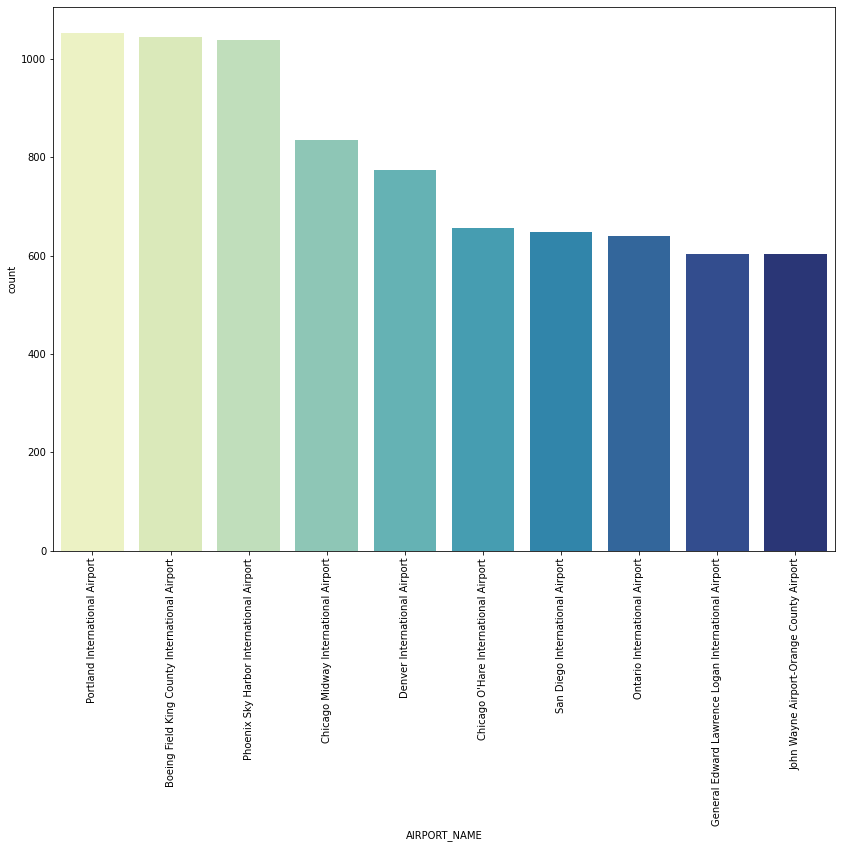

In [40]:
plt.figure(figsize=(14,10))
sns.countplot(df_new['AIRPORT_NAME'],order=df_new['AIRPORT_NAME'].value_counts()[:10].index,palette="YlGnBu")
plt.xticks(rotation=90) 

<Figure size 1008x720 with 0 Axes>

<AxesSubplot:xlabel='WATER_BODY_NAME', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Atlantic Ocean'),
  Text(1, 0, 'Pacific Ocean'),
  Text(2, 0, 'Gulf of Mexico'),
  Text(3, 0, 'Lake Michigan'),
  Text(4, 0, 'Lake Erie'),
  Text(5, 0, 'Chesapeake Bay'),
  Text(6, 0, 'Lake Ontario'),
  Text(7, 0, 'Gulf of California'),
  Text(8, 0, 'Delaware Bay'),
  Text(9, 0, 'Lake Superior')])

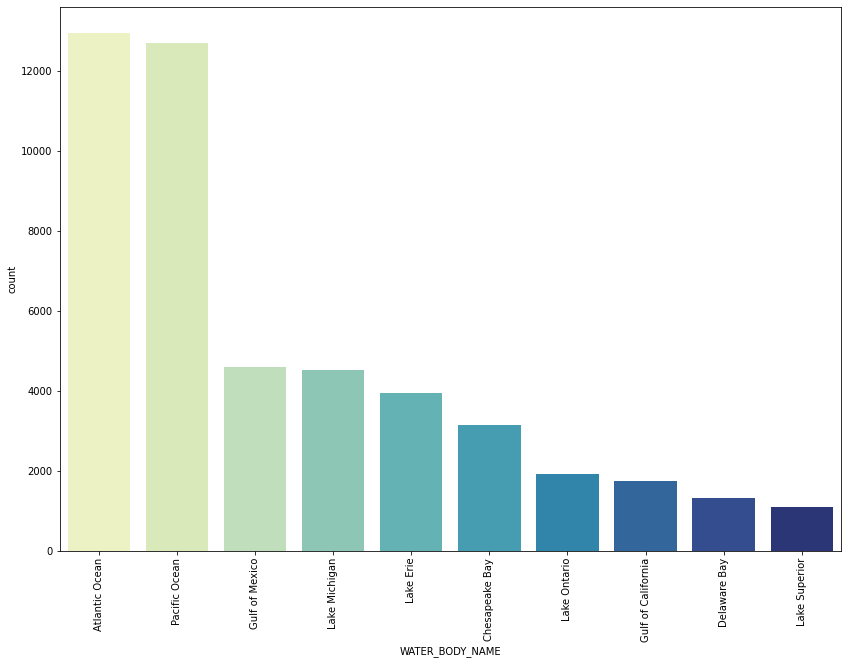

In [41]:
plt.figure(figsize=(14,10))
sns.countplot(df_new['WATER_BODY_NAME'],order=df_new['WATER_BODY_NAME'].value_counts()[:10].index,palette="YlGnBu")
plt.xticks(rotation=90) 

<Figure size 1008x720 with 0 Axes>

<AxesSubplot:xlabel='URBAN_AREA', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Los Angeles'),
  Text(1, 0, 'New York'),
  Text(2, 0, 'Phoenix'),
  Text(3, 0, 'Las Vegas'),
  Text(4, 0, 'Seattle'),
  Text(5, 0, 'San Diego'),
  Text(6, 0, 'Portland'),
  Text(7, 0, 'Chicago'),
  Text(8, 0, 'Tucson'),
  Text(9, 0, 'Houston')])

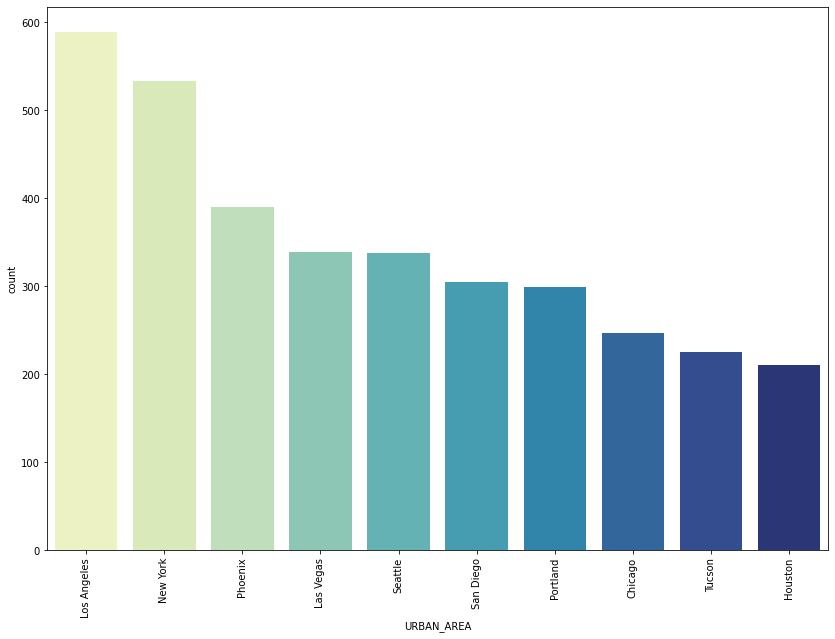

In [42]:
plt.figure(figsize=(14,10))
sns.countplot(df_new['URBAN_AREA'],order=df_new['URBAN_AREA'].value_counts()[:10].index,palette="YlGnBu")
plt.xticks(rotation=90) 

In [43]:
date=pd.to_datetime(df_new['date_time']).dt.date
posted=pd.to_datetime(df_new['posted']).dt.date

df_new['delta_posted_event'] = (posted - date).dt.days

In [44]:
missing_prop=df_new.isna().sum()/len(df_new)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA             40.224758
WATER_BODY_NAME        22.783717
shape                   2.259090
fTemp                   1.020188
precip                  1.020188
visibility              1.020188
sConditions             1.020188
AIRPORT_NAME            0.282027
AIRPORT_DISTANCE        0.277710
AIRPORT_AZIMUTH         0.277710
WATER_BODY_DISTANCE     0.277710
WATER_BODY_AZIMUTH      0.277710
dtype: float64

In [1086]:
#only rare categories:
print((df_new['AIRPORT_NAME'].value_counts())/len(df_new)*100) 

Portland International Airport                    1.514781
Boeing Field King County International Airport    1.503273
Phoenix Sky Harbor International Airport          1.494641
Chicago Midway International Airport              1.201180
Denver International Airport                      1.111990
                                                    ...   
16000.90162                                       0.001439
Cataratas International Airport                   0.001439
Philip S. W. Goldson International Airport        0.001439
Aktion National Airport                           0.001439
Pond Inlet Airport                                0.001439
Name: AIRPORT_NAME, Length: 1355, dtype: float64


In [45]:
df_new['WATER_BODY_NAME'].value_counts()/len(df_new)*100

Atlantic Ocean       18.629581
Pacific Ocean        18.264098
Gulf of Mexico        6.618991
Lake Michigan         6.516828
Lake Erie             5.685137
                       ...    
East Siberian Sea     0.001439
La Concha Bay         0.001439
Issyk Kul             0.001439
Rio Limia             0.001439
Sulawesi Sea          0.001439
Name: WATER_BODY_NAME, Length: 109, dtype: float64

In [46]:
#checking cardinality
for col in df_new.columns:
    print(f'{col}: {df_new[col].nunique()} unique values')

Text_ID: 69497 unique values
state: 65 unique values
date_time: 58055 unique values
shape: 21 unique values
text: 69250 unique values
posted: 245 unique values
Duration Category: 5 unique values
city_clean: 14204 unique values
country_python: 117 unique values
fTemp: 642 unique values
precip: 3217 unique values
visibility: 1210 unique values
sConditions: 8 unique values
AIRPORT_DISTANCE: 17525 unique values
AIRPORT_AZIMUTH: 17525 unique values
WATER_BODY_DISTANCE: 11846 unique values
WATER_BODY_AZIMUTH: 11844 unique values
WATER_BODY_NAME: 109 unique values
AIRPORT_NAME: 1340 unique values
URBAN_AREA: 4909 unique values
bIsAirport: 2 unique values
bIsNearWater: 2 unique values
bIsRuralArea: 3 unique values
delta_posted_event: 5632 unique values


<Figure size 1080x1080 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='country_python'>

Text(0.5, 1.0, 'UFO sightings by country')

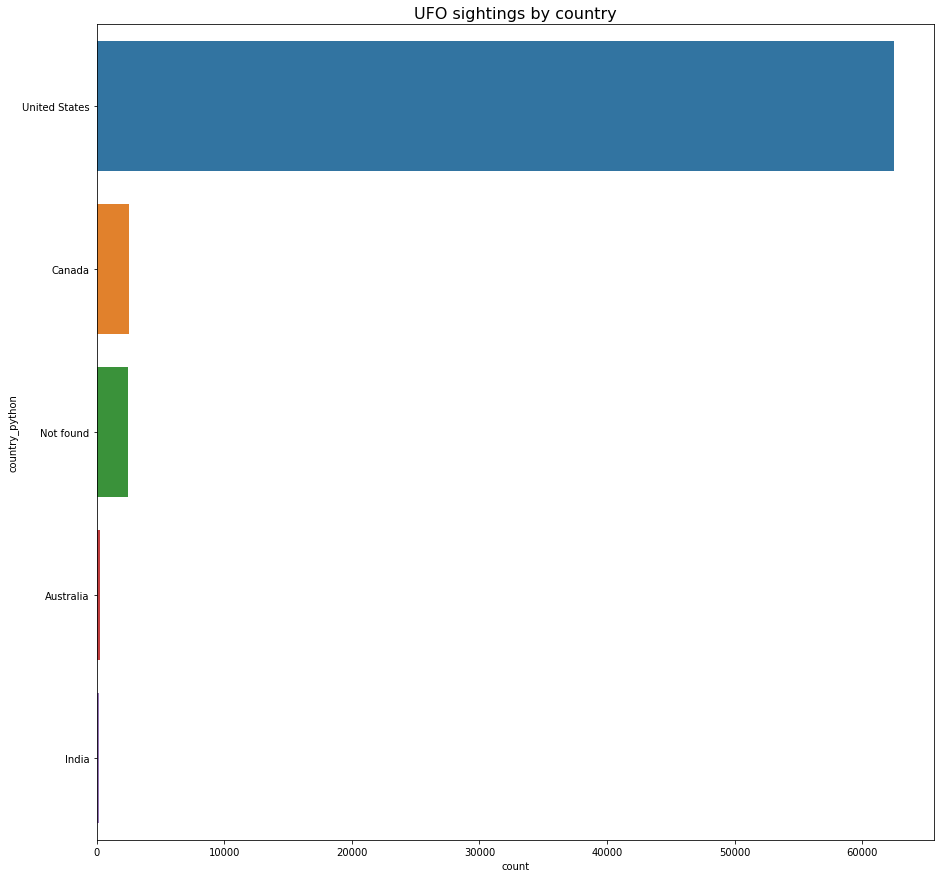

In [47]:
plt.figure(figsize=(15, 15))
sns.countplot(
    data=df_new,
    y='country_python',
    order=df['country_python'].value_counts()[:5].index
)

plt.title(
    'UFO sightings by country',
    fontdict={
        'fontsize': 16
    }
)

In [48]:
#89% of data is coming from USA. Hence,there will be no variability in the data and we must eventually drop this feature

df_new['country_python'].value_counts()/len(df_new)

United States    0.899190
Canada           0.036635
Not found        0.035599
Australia        0.003756
India            0.002993
                   ...   
Mongolia         0.000014
Oman             0.000014
Georgia          0.000014
Palau            0.000014
Faroe Islands    0.000014
Name: country_python, Length: 117, dtype: float64

<Figure size 1008x864 with 0 Axes>

<AxesSubplot:xlabel='state', ylabel='count'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'CA'),
  Text(1, 0, 'Outside US/Canada'),
  Text(2, 0, 'FL'),
  Text(3, 0, 'WA'),
  Text(4, 0, 'TX'),
  Text(5, 0, 'NY'),
  Text(6, 0, 'PA'),
  Text(7, 0, 'AZ'),
  Text(8, 0, 'OH'),
  Text(9, 0, 'IL'),
  Text(10, 0, 'NC'),
  Text(11, 0, 'MI'),
  Text(12, 0, 'OR'),
  Text(13, 0, 'NJ'),
  Text(14, 0, 'VA')])

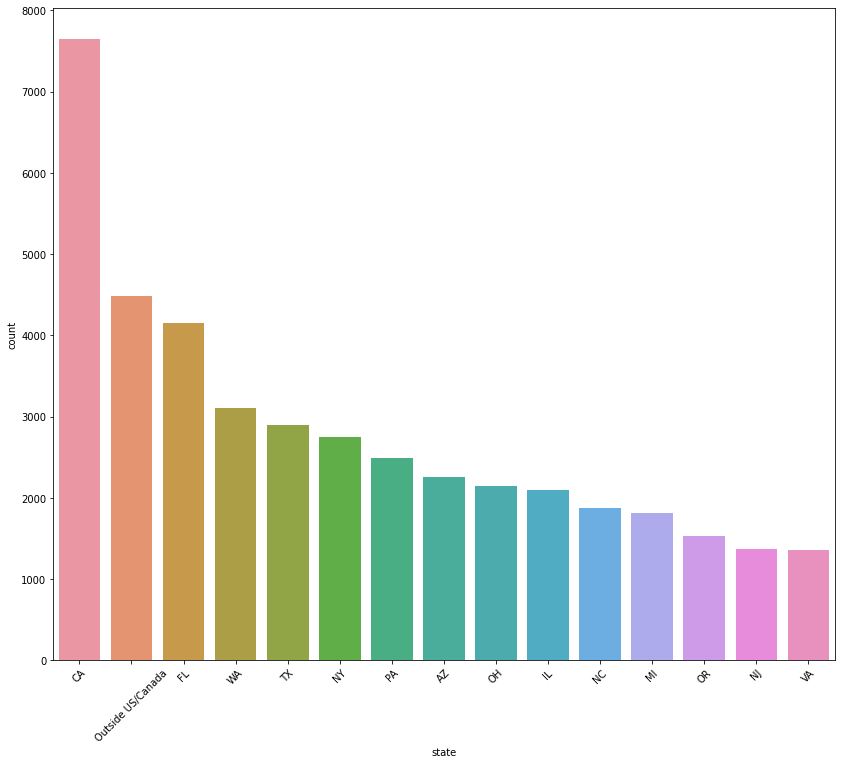

In [49]:
plt.figure(figsize=(14,12))
sns.countplot(x=df_new['state'],order=df_new['state'].value_counts()[:15].index)

plt.xticks(rotation=45) 

In [50]:
df_new['ufo_year'] = df_new['date_time'].dt.year
df_new['ufo_month'] = df_new['date_time'].dt.month
df_new['ufo_day'] = df_new['date_time'].dt.day
df_new['ufo_hour'] = df_new['date_time'].dt.hour
df_new['ufo_minute'] = df_new['date_time'].dt.minute
df_new['ufo_weekday_number'] = df_new['date_time'].dt.dayofweek #Sunday 6
df_new['ufo_weekday_name'] = df_new['date_time'].dt.day_name()

<Figure size 1008x864 with 0 Axes>

<AxesSubplot:xlabel='ufo_year', ylabel='count'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, '1969'),
  Text(1, 0, '1970'),
  Text(2, 0, '1971'),
  Text(3, 0, '1972'),
  Text(4, 0, '1973'),
  Text(5, 0, '1974'),
  Text(6, 0, '1975'),
  Text(7, 0, '1976'),
  Text(8, 0, '1977'),
  Text(9, 0, '1978'),
  Text(10, 0, '1979'),
  Text(11, 0, '1980'),
  Text(12, 0, '1981'),
  Text(13, 0, '1982'),
  Text(14, 0, '1983'),
  Text(15, 0, '1984'),
  Text(16, 0, '1985'),
  Text(17, 0, '1986'),
  Text(18, 0, '1987'),
  Text(19, 0, '1988'),
  Text(20, 0, '1989'),
  Text(21, 0, '1990'),
  Text(22, 0, '1991'),
  Text(23, 0, '1992'),
  Text(24, 0, '1993'),
  Text(25, 0, '1994'),
  Text(26, 0, '1995'),
  Text(27, 0, '1996'),
  Text(28, 0, '1997'),
  Text(29, 0, '1998'),
  Text(30, 0, '1999'),
  Text(31, 0, '2000'),
  Text(32, 0, '2001'),
  Text(33, 0, '2002')

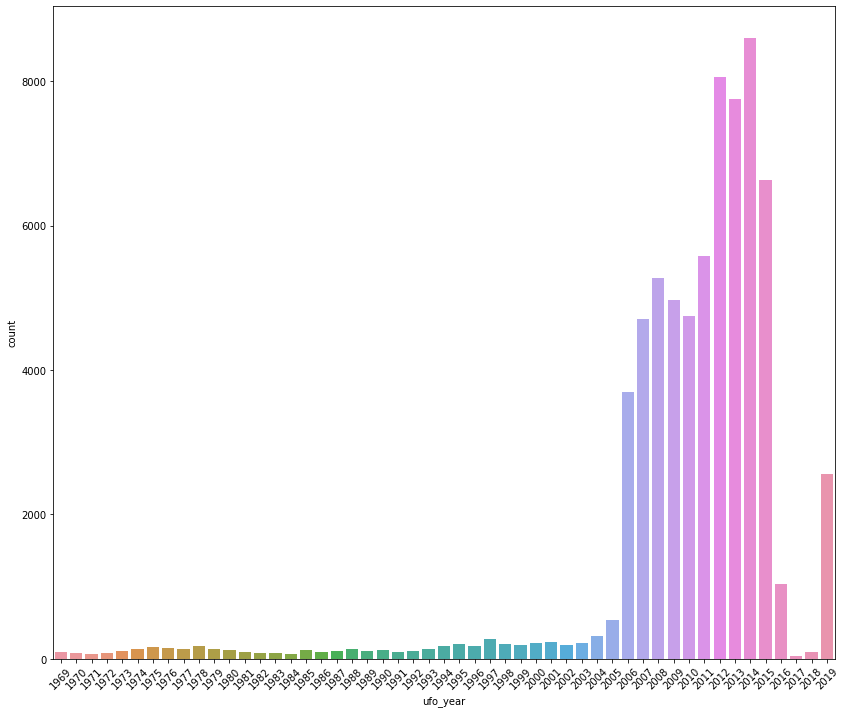

In [51]:
#big drop in 2016-2018
plt.figure(figsize=(14,12))
sns.countplot(x=df_new["ufo_year"])

plt.xticks(rotation=45) 

<AxesSubplot:>

Text(0.5, 1.0, 'Global UFO Sightings by Month')

Text(0.5, 0, 'Month')

Text(0, 0.5, '# Sightings')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

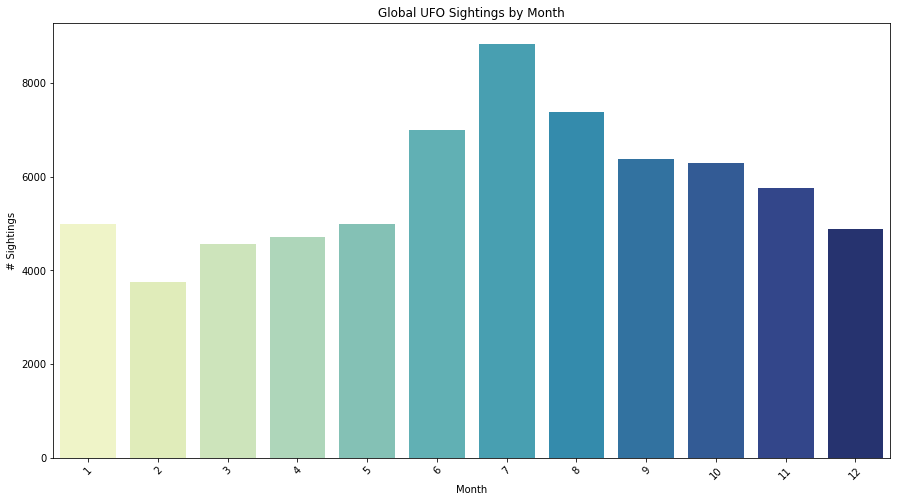

In [52]:
#most of sightings appear in July. Pick season June - October

m_cts = (df_new['ufo_month'].value_counts()).sort_index()
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(15,8))

sns.barplot(x=m_ctsx, y=m_ctsy, palette="YlGnBu")
ax.set_title('Global UFO Sightings by Month')
ax.set_xlabel('Month')
ax.set_ylabel('# Sightings')
plt.xticks(rotation=45)

In [53]:
def season_search(row):
    if row in range (3,6):
        return 'Spring'
    elif row in range(6,9):
        return 'Summer'
    elif row in range(9,12):
        return 'Fall'
    else:
        return 'Winter'
df_new["season"]=df_new["ufo_month"].apply(season_search)  

<AxesSubplot:xlabel='season', ylabel='count'>

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Winter'),
  Text(1, 0, 'Spring'),
  Text(2, 0, 'Summer'),
  Text(3, 0, 'Fall')])

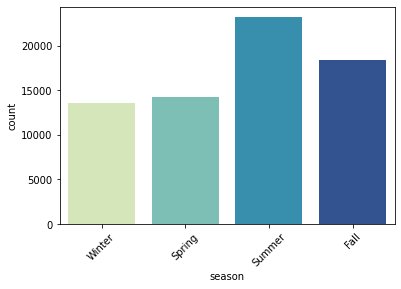

In [54]:
sns.countplot(x='season',data=df_new,palette="YlGnBu")

plt.xticks(rotation=45)

<AxesSubplot:xlabel='Duration Category', ylabel='count'>

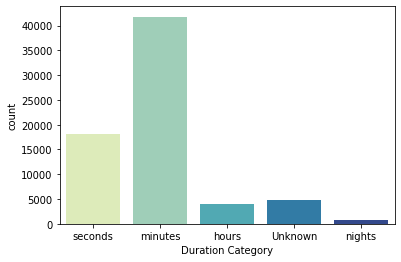

In [55]:
#imbalanced dataset -->will need to handle before modelling
sns.countplot(df_new['Duration Category'],palette="YlGnBu") 

<AxesSubplot:xlabel='season', ylabel='count'>

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Winter'),
  Text(1, 0, 'Spring'),
  Text(2, 0, 'Summer'),
  Text(3, 0, 'Fall')])

Text(0.5, 1.0, 'Global UFO Sightings duration by season')

Text(0.5, 0, 'Season')

Text(0, 0.5, '# Sightings')

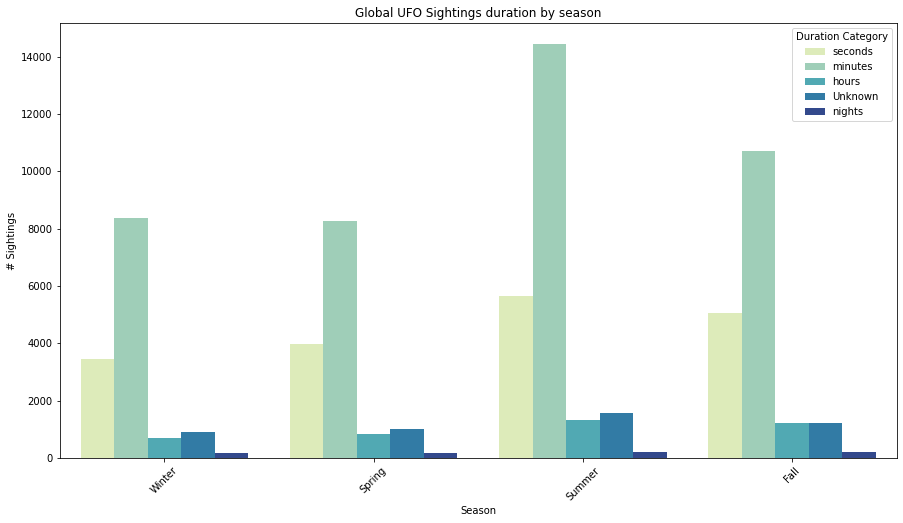

In [56]:
#regardless of season, most durations are in minutes and seconds across the board
f, ax = plt.subplots(figsize=(15,8))

sns.countplot(x='season',hue='Duration Category',data=df_new,palette="YlGnBu")

plt.xticks(rotation=45)
ax.set_title('Global UFO Sightings duration by season')
ax.set_xlabel('Season')
ax.set_ylabel('# Sightings')

<AxesSubplot:>

Text(0.5, 1.0, 'Global UFO Sightings by Month')

Text(0.5, 0, 'Month')

Text(0, 0.5, '# Sightings')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

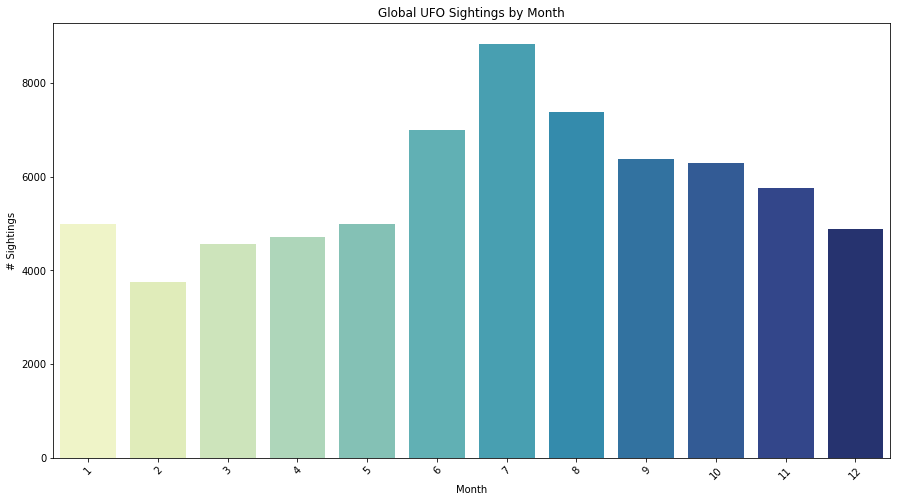

In [57]:
#most of sightings appear in July. Pick season June - October

m_cts = (df_new['ufo_month'].value_counts()).sort_index()
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(15,8))

sns.barplot(x=m_ctsx, y=m_ctsy, palette="YlGnBu")
ax.set_title('Global UFO Sightings by Month')
ax.set_xlabel('Month')
ax.set_ylabel('# Sightings')
plt.xticks(rotation=45)

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='ufo_day', ylabel='count'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31')])

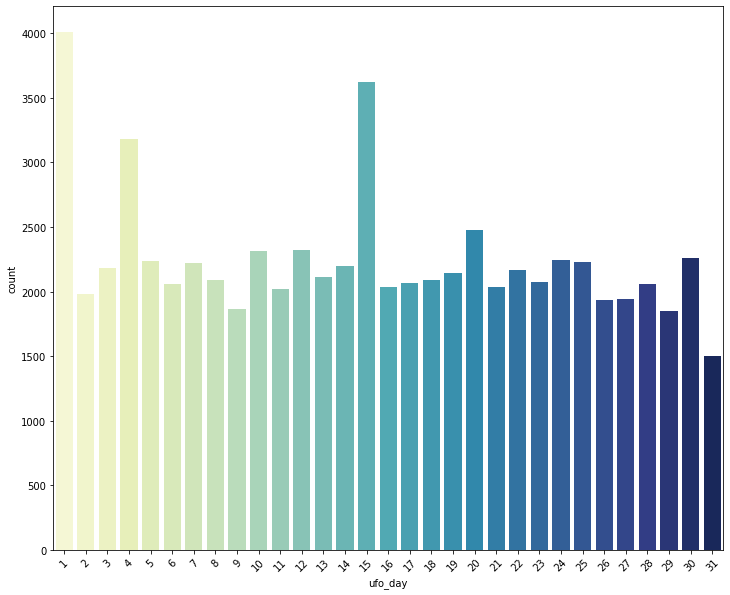

In [58]:
#UFO comes mostly at the begin and mid month
plt.figure(figsize=(12,10))
sns.countplot(df_new['ufo_day'],palette="YlGnBu")

plt.xticks(rotation=45)

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='ufo_weekday_name', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Thursday'),
  Text(1, 0, 'Friday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Sunday'),
  Text(4, 0, 'Tuesday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Monday')])

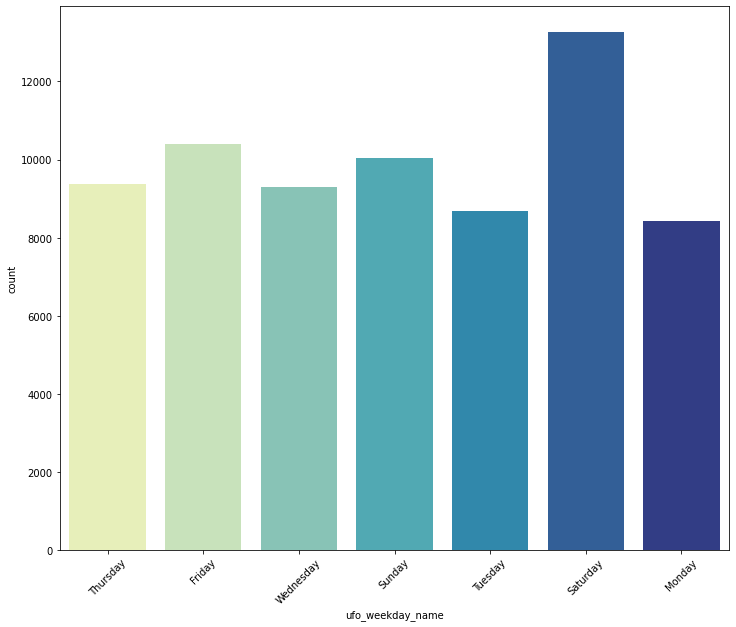

In [59]:
plt.figure(figsize=(12,10))
sns.countplot(df_new['ufo_weekday_name'],palette="YlGnBu")

plt.xticks(rotation=45)

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='ufo_hour', ylabel='count'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

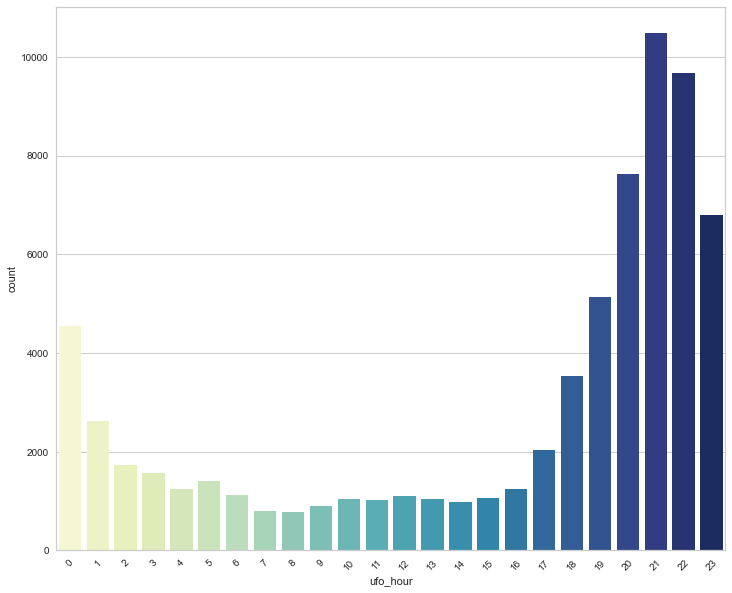

In [1001]:
#UFO is mostly coming in the evening
plt.figure(figsize=(12,10))
sns.countplot(df_new['ufo_hour'],palette="YlGnBu")

plt.xticks(rotation=45)

In [60]:
def time_interval(row):
    if row in range (0,5):
        return 'Night'
    elif row in range(5,12):
        return 'Morning'
    elif row in range(11,17):
        return 'Afternoon'
    else:
        return 'Evening'
df_new["time_of_day"]=df_new["ufo_hour"].apply(time_interval)  

<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='time_of_day', ylabel='count'>

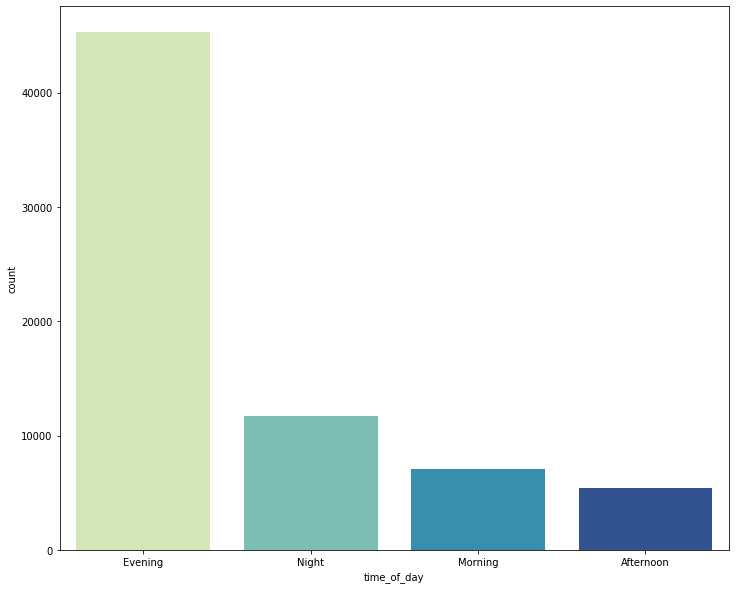

In [61]:
plt.figure(figsize=(12,10))
sns.countplot(df_new['time_of_day'],palette="YlGnBu")

In [62]:
# creating cyclical hour feature.
df_new['ufo_month_sin'] = np.sin(df_new['ufo_month'] * (2. * np.pi / 12 ))
df_new['ufo_month_cos'] = np.cos(df_new['ufo_month'] * (2. * np.pi / 12 ))

# creating cyclical minute feature.
df_new['ufo_day_sin'] = np.sin(df_new['ufo_day'] * (2. * np.pi / 30 ))
df_new['ufo_day_cos'] = np.cos(df_new['ufo_day'] * (2. * np.pi / 30 ))

# creating cyclical month days feature.
df_new['ufo_hour_sin'] = np.sin((df_new['ufo_hour'] - 1) * (2. * np.pi / 24 ))
df_new['ufo_hour_cos'] = np.cos((df_new['ufo_hour'] - 1) * (2. * np.pi / 24 ))

# creating cyclical minute days feature.
df_new['ufo_minute_sin'] = np.sin((df_new['ufo_minute'] - 1) * (2. * np.pi / 60 ))
df_new['ufo_minute_cos'] = np.cos((df_new['ufo_minute'] - 1) * (2. * np.pi / 60 ))

# creating cyclical minute days feature.
df_new['ufo_weekday_sin'] = np.sin((df_new['ufo_weekday_number'] - 1) * (2. * np.pi / 7 ))
df_new['ufo_weekday_cos'] = np.cos((df_new['ufo_weekday_number'] - 1) * (2. * np.pi / 7 ))

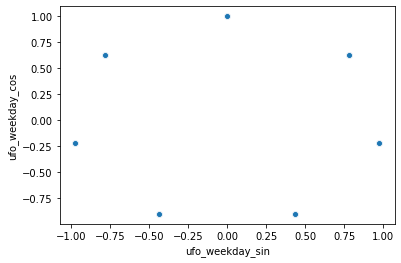

In [63]:
ax = sns.scatterplot(x="ufo_weekday_sin", y = "ufo_weekday_cos",data=df_new)

In [64]:
df_new=df_new.dropna(how='all',
                    subset=['AIRPORT_DISTANCE', 'AIRPORT_AZIMUTH','WATER_BODY_DISTANCE','WATER_BODY_AZIMUTH'])

In [65]:
missing_prop=df_new.isna().sum()/len(df_new)
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA         0.400583
WATER_BODY_NAME    0.225687
shape              0.021701
fTemp              0.008066
precip             0.008066
visibility         0.008066
sConditions        0.008066
AIRPORT_NAME       0.000043
dtype: float64

In [66]:
# creating surrogates for missing values except columns that I won't take for modelling
columns=list(set(df_new.columns)-set(df_new[['URBAN_AREA','AIRPORT_NAME']].columns))

for col in df_new[columns]:
    if df_new[col].isna().sum() != 0: 
        df_new[col + '_surrogate'] = df_new[col].isna().astype(int)

In [67]:
df_new['WATER_BODY_NAME']=df_new['WATER_BODY_NAME'].fillna('Unknown')

In [68]:
 with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_new[df_new['city_clean']=='Kiev']

,Text_ID,state,date_time,shape,text,posted,Duration Category,city_clean,country_python,fTemp,precip,visibility,sConditions,AIRPORT_DISTANCE,AIRPORT_AZIMUTH,WATER_BODY_DISTANCE,WATER_BODY_AZIMUTH,WATER_BODY_NAME,AIRPORT_NAME,URBAN_AREA,bIsAirport,bIsNearWater,bIsRuralArea,delta_posted_event,ufo_year,ufo_month,ufo_day,ufo_hour,ufo_minute,ufo_weekday_number,ufo_weekday_name,season,time_of_day,ufo_month_sin,ufo_month_cos,ufo_day_sin,ufo_day_cos,ufo_hour_sin,ufo_hour_cos,ufo_minute_sin,ufo_minute_cos,ufo_weekday_sin,ufo_weekday_cos,precip_surrogate,fTemp_surrogate,sConditions_surrogate,visibility_surrogate,WATER_BODY_NAME_surrogate,shape_surrogate
15920,16398,Outside US/Canada,2009-09-11 21:55:00,fireball,red light over Kiev (Ukraine) Dear ufologists!...,2009-12-12,minutes,Kiev,Ukraine,20.8,0.0,17.4,Clear,7465.8,-136.4,-1.0,0.0,Unknown,Kiev Zhuliany International Airport,None,1,0,Unknown,92,2009,9,11,21,55,4,Friday,Fall,Evening,-1.0,-0.0,0.7,-0.7,-0.9,0.5,-0.6,0.8,0.4,-0.9,0,0,0,0,1,0
31958,32639,Outside US/Canada,2011-11-09 12:00:00,flash,Blue flash lights over the top of the Kiev pla...,2011-12-12,seconds,Kiev,Ukraine,5.0,1.0,8.9,Drizzle,7465.8,-136.4,-1.0,0.0,Unknown,Kiev Zhuliany International Airport,None,1,0,Unknown,33,2011,11,9,12,0,2,Wednesday,Fall,Afternoon,-0.5,0.9,1.0,-0.3,0.3,-1.0,-0.1,1.0,0.8,0.6,0,0,0,0,1,0
31959,32640,Outside US/Canada,2011-11-09 12:00:00,flash,"BLUE DOTS OVER KYIV PLANETARIUM, UKRAINE, KYIV...",2011-12-12,minutes,Kiev,Ukraine,5.0,1.0,8.9,Drizzle,7465.8,-136.4,-1.0,0.0,Unknown,Kiev Zhuliany International Airport,None,1,0,Unknown,33,2011,11,9,12,0,2,Wednesday,Fall,Afternoon,-0.5,0.9,1.0,-0.3,0.3,-1.0,-0.1,1.0,0.8,0.6,0,0,0,0,1,0


<Figure size 864x720 with 0 Axes>

<AxesSubplot:xlabel='shape', ylabel='count'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'light'),
  Text(1, 0, 'circle'),
  Text(2, 0, 'teardrop'),
  Text(3, 0, 'cigar'),
  Text(4, 0, 'disk'),
  Text(5, 0, 'unknown'),
  Text(6, 0, 'oval'),
  Text(7, 0, 'other'),
  Text(8, 0, 'sphere'),
  Text(9, 0, 'changing'),
  Text(10, 0, 'formation'),
  Text(11, 0, 'flash'),
  Text(12, 0, 'chevron'),
  Text(13, 0, 'triangle'),
  Text(14, 0, 'fireball'),
  Text(15, 0, 'cross'),
  Text(16, 0, 'rectangle'),
  Text(17, 0, 'diamond'),
  Text(18, 0, 'cylinder'),
  Text(19, 0, 'egg'),
  Text(20, 0, 'cone')])

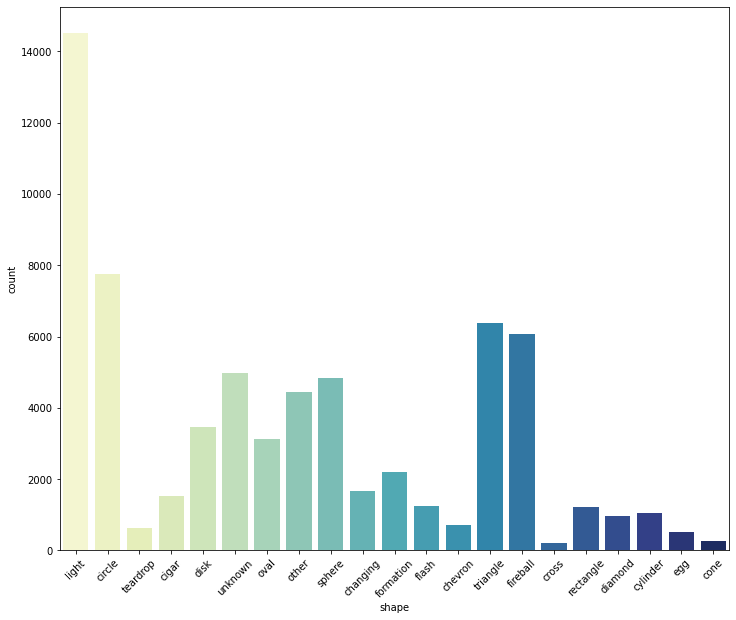

In [69]:
plt.figure(figsize=(12,10))
sns.countplot(df_new['shape'],palette="YlGnBu")

plt.xticks(rotation=45)

In [70]:
df_new['shape'] = np.where((df_new['shape']=='circle'),'disk',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'oval'),'disk',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'round'),'disk',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'sphere'),'ball',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'fireball'),'ball',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'cigar'),'cylinder',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'cone'),'cylinder',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'rectangle'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'chevron'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'triangle'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'diamond'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'cross'),'geometric',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'formation'),'changing',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'unknown'),'other',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'egg'),'other',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'teardrop'),'other',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'flash'),'light',df_new['shape'])

df_new['shape']=df_new['shape'].fillna('missing_value')

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='shape', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'light'),
  Text(1, 0, 'disk'),
  Text(2, 0, 'other'),
  Text(3, 0, 'cylinder'),
  Text(4, 0, 'ball'),
  Text(5, 0, 'changing'),
  Text(6, 0, 'geometric'),
  Text(7, 0, 'missing_value')])

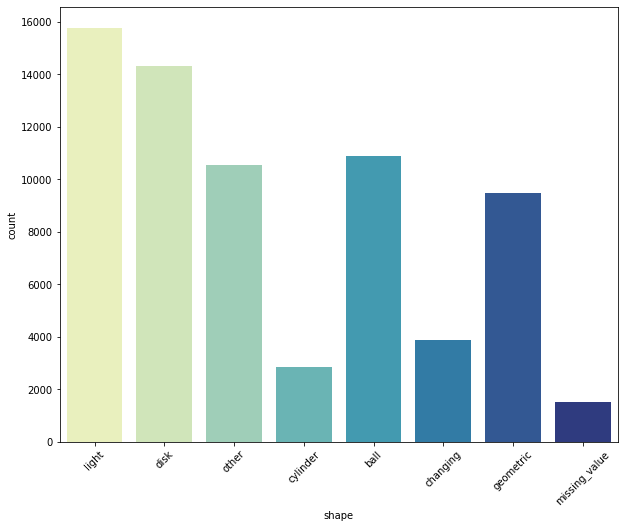

In [71]:
plt.figure(figsize=(10,8))
sns.countplot(df_new['shape'],palette="YlGnBu")

plt.xticks(rotation=45)

In [72]:
print((df_new['shape'].value_counts()/len(df_new))*100)

light            22.766363
disk             20.677017
ball             15.740794
other            15.224229
geometric        13.707722
changing          5.594194
cylinder          4.119531
missing_value     2.170149
Name: shape, dtype: float64


In [73]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid=SentimentIntensityAnalyzer()

#adding a column with compound scores
df_new['sentiment_compound']=df_new['text'].apply(lambda r:sid.polarity_scores(r)["compound"])

In [74]:
def score_classifier(row):
    if row>0:
        return 1
    elif row<0:
        return -1
    else:
        return 0
df_new['sentiment']=df_new['sentiment_compound'].apply(score_classifier)

#dropping value of sentiment_compound,keeping sentiment only
df_new.drop(["sentiment_compound"],axis=1,inplace=True)

In [75]:
df_new.drop(['AIRPORT_NAME','URBAN_AREA','bIsAirport'],axis=1,inplace=True)

In [76]:
missing_prop=df_new.isna().sum()/len(df_new)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

fTemp          0.806591
precip         0.806591
visibility     0.806591
sConditions    0.806591
dtype: float64

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Temperature')

Text(0.5, 0, 'Temperature')

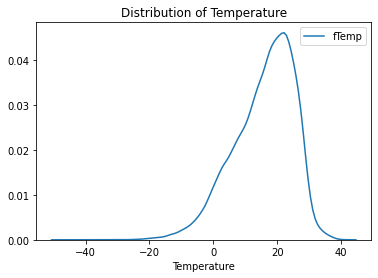

In [77]:
sns.kdeplot(df_new['fTemp'])
plt.title('Distribution of Temperature')
plt.xlabel('Temperature')

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Precipitation')

Text(0.5, 0, 'Precipitation')

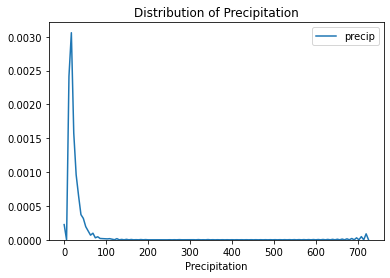

In [78]:
sns.kdeplot(df_new['precip'])
plt.title('Distribution of Precipitation')
plt.xlabel('Precipitation')

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Visibility')

Text(0.5, 0, 'Visibility')

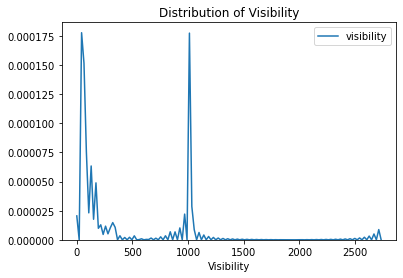

In [79]:
sns.kdeplot(df_new['visibility'])
plt.title('Distribution of Visibility')
plt.xlabel('Visibility')

In [80]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_new[0:3]

,Text_ID,state,date_time,shape,text,posted,Duration Category,city_clean,country_python,fTemp,precip,visibility,sConditions,AIRPORT_DISTANCE,AIRPORT_AZIMUTH,WATER_BODY_DISTANCE,WATER_BODY_AZIMUTH,WATER_BODY_NAME,bIsNearWater,bIsRuralArea,delta_posted_event,ufo_year,ufo_month,ufo_day,ufo_hour,ufo_minute,ufo_weekday_number,ufo_weekday_name,season,time_of_day,ufo_month_sin,ufo_month_cos,ufo_day_sin,ufo_day_cos,ufo_hour_sin,ufo_hour_cos,ufo_minute_sin,ufo_minute_cos,ufo_weekday_sin,ufo_weekday_cos,precip_surrogate,fTemp_surrogate,sConditions_surrogate,visibility_surrogate,WATER_BODY_NAME_surrogate,shape_surrogate,sentiment
0,1,VA,2019-12-12 18:43:00,light,My wife was driving southeast on a fairly popu...,2019-12-22,seconds,Chester,United States,-0.3,0.0,16.0,Clear,19630.4,23.6,10600.2,109.4,Chesapeake Bay,1,urban,10,2019,12,12,18,43,3,Thursday,Winter,Evening,-0.0,1.0,0.6,-0.8,-1.0,-0.3,-1.0,-0.3,1.0,-0.2,0,0,0,0,0,0,-1
1,2,CT,2019-03-22 18:30:00,disk,I think that I may caught a UFO on the NBC Nig...,2019-03-29,seconds,Rocky Hill,United States,5.1,12.5,12.7,Mist,30661.9,-6.8,37413.9,177.9,Atlantic Ocean,1,rural,7,2019,3,22,18,30,4,Friday,Spring,Evening,1.0,0.0,-1.0,-0.1,-1.0,-0.3,0.1,-1.0,0.4,-0.9,0,0,0,0,0,0,0
2,4,ON,2019-04-17 02:00:00,other,I was driving towards the intersection of fall...,2019-04-18,seconds,Ottawa,Canada,6.9,0.0,1020.4,Clear,7232.8,154.8,102885.7,-177.6,Lake Ontario,1,rural,1,2019,4,17,2,0,2,Wednesday,Spring,Night,0.9,-0.5,-0.4,-0.9,0.3,1.0,-0.1,1.0,0.8,0.6,0,0,0,0,0,0,-1


In [81]:
df_new['sConditions']=df_new['sConditions'].fillna('missing_value')

In [83]:
#a bit skewed, so I will winsorize outliers first
df_new['fTemp'].skew() 

-0.7172459883731263

In [84]:
print('Temperature skewness:')
print(df_new['fTemp'].skew())
print('\n')
print('Precipitation skewness:')
print(df_new['precip'].skew())
print('\n')
print('Visibility skewness')
print(df_new['visibility'].skew())

Temperature skewness:
-0.7172459883731263


Precipitation skewness:
19.797100823424735


Visibility skewness
14.691415480408391


In [85]:
from scipy.stats.mstats import winsorize
#winsorization has a default setting to propagate NaN: allows nan values and may overwrite or propagate them
#Replacing the outliers on the upper side with 95% percentile value and outlier on the lower side with 5% percentile

df_new['fTemp_winsorized'] = winsorize(df_new['fTemp'],limits =[0.05, 0.05])
df_new['fTemp'].max(),df_new['fTemp_winsorized'].max(),df_new['fTemp'].min(),df_new['fTemp_winsorized'].min()

(41.4, 28.6, -47.4, -1.4)

In [86]:
df_new['fTemp_winsorized'].skew()

-0.4603232412285926

In [87]:
df_new['precip'].skew() 

19.797100823424735

In [88]:
df_new.kurtosis(numeric_only=True)

Text_ID                        -1.197031
fTemp                           0.390246
precip                       1233.751577
visibility                    236.743955
AIRPORT_DISTANCE                7.781441
AIRPORT_AZIMUTH                -1.254447
WATER_BODY_DISTANCE             0.917607
WATER_BODY_AZIMUTH             -0.798881
bIsNearWater                   -0.277548
delta_posted_event             20.449818
ufo_year                       11.503824
ufo_month                      -0.950109
ufo_day                        -1.181106
ufo_hour                       -0.627759
ufo_minute                     -1.153401
ufo_weekday_number             -1.219948
ufo_month_sin                  -1.357401
ufo_month_cos                  -1.491990
ufo_day_sin                    -1.412966
ufo_day_cos                    -1.535913
ufo_hour_sin                    0.096801
ufo_hour_cos                   -0.317574
ufo_minute_sin                 -0.120350
ufo_minute_cos                 -1.504493
ufo_weekday_sin 

In [89]:
df_new['precip_winsorized'] = winsorize(df_new['precip'],limits =[0.05, 0.05]) 
df_new['precip'].max(),df_new['precip_winsorized'].max(),df_new['precip'].min(),df_new['precip_winsorized'].min()

(726.21, 14.37, 0.0, 0.0)

In [90]:
df_new['precip_winsorized'].skew()

2.6176120045129556

<AxesSubplot:>

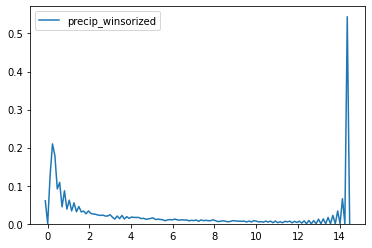

In [91]:
sns.kdeplot(df_new['precip_winsorized'])

In [92]:
df_new['precip_winsorized']=np.sqrt(df_new['precip_winsorized']) #Square root 

<AxesSubplot:>

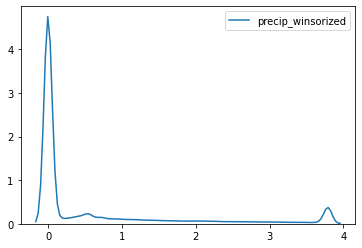

In [93]:
sns.kdeplot(df_new['precip_winsorized'])

In [94]:
df_new['precip_winsorized'].skew()

1.8897698216390948

In [95]:
df_new['visibility'].skew()

14.691415480408391

In [96]:
df_new['visibility_winsorized'] = winsorize(df_new['visibility'],limits =[0.05, 0.05]) 
df_new['visibility'].max(),df_new['visibility_winsorized'].max(),df_new['visibility'].min(),df_new['visibility_winsorized'].min()

(2733.3, 24.0, 0.0, 9.7)

<AxesSubplot:>

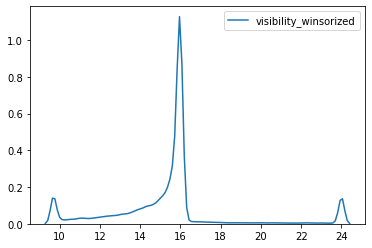

In [97]:
sns.kdeplot(df_new['visibility_winsorized'])

In [98]:
df_new['visibility_winsorized'].skew()

0.9157196085109379

In [99]:
print('Temperature skewness:')
print(df_new['fTemp_winsorized'].skew())
print('\n')
print('Precipitation skewness:')
print(df_new['precip_winsorized'].skew())
print('\n')
print('Visibility skewness')
print(df_new['visibility_winsorized'].skew())

Temperature skewness:
-0.4603232412285926


Precipitation skewness:
1.8897698216390948


Visibility skewness
0.9157196085109379


In [100]:
#dropping columns since I winsorized them already
df_new.drop(['fTemp','precip','visibility'],axis=1,inplace=True)

In [101]:
#I don't worry about ufo_year because I will drop it for modelling. Surrogates often have high kurtosis as well
df_new.kurtosis(numeric_only=True)

Text_ID                       -1.197031
AIRPORT_DISTANCE               7.781441
AIRPORT_AZIMUTH               -1.254447
WATER_BODY_DISTANCE            0.917607
WATER_BODY_AZIMUTH            -0.798881
bIsNearWater                  -0.277548
delta_posted_event            20.449818
ufo_year                      11.503824
ufo_month                     -0.950109
ufo_day                       -1.181106
ufo_hour                      -0.627759
ufo_minute                    -1.153401
ufo_weekday_number            -1.219948
ufo_month_sin                 -1.357401
ufo_month_cos                 -1.491990
ufo_day_sin                   -1.412966
ufo_day_cos                   -1.535913
ufo_hour_sin                   0.096801
ufo_hour_cos                  -0.317574
ufo_minute_sin                -0.120350
ufo_minute_cos                -1.504493
ufo_weekday_sin               -1.470164
ufo_weekday_cos               -1.489322
precip_surrogate             118.995336
fTemp_surrogate              118.995336


In [102]:
df_new['delta_posted_event'].skew()

4.477023183982625

<AxesSubplot:>

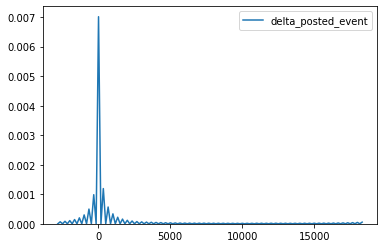

In [103]:
sns.kdeplot(df_new['delta_posted_event'])

In [104]:
#there are too many outliers to drop so I decided to winsorize 9%

df_new['delta_posted_event_winsorized'] = winsorize(df_new['delta_posted_event'],limits =[0.09, 0.09]) 
df_new['delta_posted_event'].max(),df_new['delta_posted_event_winsorized'].max(),df_new['delta_posted_event'].min(),df_new['delta_posted_event_winsorized'].min()

(18315, 912, -2783, 2)

In [105]:
df_new['delta_posted_event_winsorized'].skew()

2.4443473753809513

In [106]:
df_new.drop('delta_posted_event',axis=1,inplace=True)

In [107]:
df_new.kurtosis(numeric_only=True)

Text_ID                           -1.197031
AIRPORT_DISTANCE                   7.781441
AIRPORT_AZIMUTH                   -1.254447
WATER_BODY_DISTANCE                0.917607
WATER_BODY_AZIMUTH                -0.798881
bIsNearWater                      -0.277548
ufo_year                          11.503824
ufo_month                         -0.950109
ufo_day                           -1.181106
ufo_hour                          -0.627759
ufo_minute                        -1.153401
ufo_weekday_number                -1.219948
ufo_month_sin                     -1.357401
ufo_month_cos                     -1.491990
ufo_day_sin                       -1.412966
ufo_day_cos                       -1.535913
ufo_hour_sin                       0.096801
ufo_hour_cos                      -0.317574
ufo_minute_sin                    -0.120350
ufo_minute_cos                    -1.504493
ufo_weekday_sin                   -1.470164
ufo_weekday_cos                   -1.489322
precip_surrogate                

In [108]:
missing_prop=df_new.isna().sum()/len(df_new)
missing_prop[missing_prop>0].sort_values(ascending=False)

Series([], dtype: float64)

In [109]:
#combining rate categories:

def CombineRareCategories(data,pct):
    for col in data[['state','shape','WATER_BODY_NAME','bIsRuralArea','sConditions']].columns:
        for index,row in pd.DataFrame(data[col].value_counts()/len(data)*100).iterrows():
                if (row[0]<pct):
                    data[col].replace(index,'Other_'+col,inplace=True)
                else:
                    None
CombineRareCategories(df_new,4.0)

In [110]:
print(df_new['state'].value_counts()/len(df_new)*100)

Other_state          68.082650
CA                   11.013794
Outside US/Canada     6.272365
FL                    5.990996
WA                    4.474489
TX                    4.165705
Name: state, dtype: float64


In [111]:
print(df_new['shape'].value_counts()/len(df_new)*100)

light          22.766363
disk           20.677017
ball           15.740794
other          15.224229
geometric      13.707722
changing        5.594194
cylinder        4.119531
Other_shape     2.170149
Name: shape, dtype: float64


In [112]:
print(df_new['WATER_BODY_NAME'].value_counts()/len(df_new)*100)

Unknown                  22.568683
Atlantic Ocean           18.681461
Pacific Ocean            18.314960
Other_WATER_BODY_NAME    17.030763
Gulf of Mexico            6.637424
Lake Michigan             6.534976
Lake Erie                 5.700970
Chesapeake Bay            4.530763
Name: WATER_BODY_NAME, dtype: float64


In [113]:
print(df_new['sConditions'].value_counts()/len(df_new)*100)

Clear                39.205529
Mist                 23.899053
Fog                  11.787198
Rain                 11.513044
Drizzle               5.957809
Haze                  4.040171
Other_sConditions     3.597195
Name: sConditions, dtype: float64


In [114]:
#doing OHE for some features using get_dummies
original_columns=list(set(df_new.columns)-set(df_new[['state','shape','WATER_BODY_NAME','bIsRuralArea','sConditions']].columns))

df_full=pd.concat([df_new[original_columns],pd.get_dummies(df_new[['state','shape','WATER_BODY_NAME','bIsRuralArea','sConditions']])],axis=1)

In [115]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_full[0:3]

,posted,delta_posted_event_winsorized,WATER_BODY_AZIMUTH,fTemp_winsorized,season,WATER_BODY_NAME_surrogate,date_time,ufo_minute_sin,city_clean,bIsNearWater,sConditions_surrogate,ufo_hour_sin,AIRPORT_AZIMUTH,AIRPORT_DISTANCE,ufo_minute,ufo_day_cos,ufo_month_cos,ufo_weekday_cos,country_python,ufo_day_sin,precip_winsorized,ufo_month_sin,ufo_hour_cos,ufo_weekday_number,ufo_month,Text_ID,ufo_hour,ufo_year,ufo_day,shape_surrogate,fTemp_surrogate,time_of_day,sentiment,WATER_BODY_DISTANCE,ufo_minute_cos,text,ufo_weekday_sin,visibility_surrogate,precip_surrogate,visibility_winsorized,ufo_weekday_name,Duration Category,state_CA,state_FL,state_Other_state,state_Outside US/Canada,state_TX,state_WA,shape_Other_shape,shape_ball,shape_changing,shape_cylinder,shape_disk,shape_geometric,shape_light,shape_other,WATER_BODY_NAME_Atlantic Ocean,WATER_BODY_NAME_Chesapeake Bay,WATER_BODY_NAME_Gulf of Mexico,WATER_BODY_NAME_Lake Erie,WATER_BODY_NAME_Lake Michigan,WATER_BODY_NAME_Other_WATER_BODY_NAME,WATER_BODY_NAME_Pacific Ocean,WATER_BODY_NAME_Unknown,bIsRuralArea_Unknown,bIsRuralArea_rural,bIsRuralArea_urban,sConditions_Clear,sConditions_Drizzle,sConditions_Fog,sConditions_Haze,sConditions_Mist,sConditions_Other_sConditions,sConditions_Rain
0,2019-12-22,10,109.4,-0.3,Winter,0,2019-12-12 18:43:00,-1.0,Chester,1,0,-1.0,23.6,19630.4,43,-0.8,1.0,-0.2,United States,0.6,0.0,-0.0,-0.3,3,12,1,18,2019,12,0,0,Evening,-1,10600.2,-0.3,My wife was driving southeast on a fairly popu...,1.0,0,0,16.0,Thursday,seconds,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,2019-03-29,7,177.9,5.1,Spring,0,2019-03-22 18:30:00,0.1,Rocky Hill,1,0,-1.0,-6.8,30661.9,30,-0.1,0.0,-0.9,United States,-1.0,3.5,1.0,-0.3,4,3,2,18,2019,22,0,0,Evening,0,37413.9,-1.0,I think that I may caught a UFO on the NBC Nig...,0.4,0,0,12.7,Friday,seconds,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,2019-04-18,2,-177.6,6.9,Spring,0,2019-04-17 02:00:00,-0.1,Ottawa,1,0,0.3,154.8,7232.8,0,-0.9,-0.5,0.6,Canada,-0.4,0.0,0.9,1.0,2,4,4,2,2019,17,0,0,Night,-1,102885.7,1.0,I was driving towards the intersection of fall...,0.8,0,0,24.0,Wednesday,seconds,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0


In [116]:
df_full=df_full.replace('nan',np.NaN)
df_full=df_full.replace(r'^\s*$',np.NaN,regex=True)

In [117]:
df_full=df_full.dropna(subset = ['text'],how='any')

In [118]:
wn=nltk.WordNetLemmatizer()
stop_words=set(stopwords.words('english')+stopwords.words('spanish')+['u','im','dont','cuz','lol','ur','ure','doing','nuforc note','ufo','see','nuforc'])
from textblob import TextBlob


def clean_text(text):
          
    text="".join([char.lower() for char in text if char not in string.punctuation])
    text= re.sub(r'\d+', '', text)
    text=re.sub(r'http\S+|www\S+', '', text).strip()
    tokens=nltk.word_tokenize(text.strip())
    text=[t for t in tokens if t not in stop_words]
    text=[unidecode.unidecode(w) for w in text]
    text=" ".join([wn.lemmatize(word,'v')for word in text])
    text=" ".join([word for word in text.split()]) 
    return text

df_full["text_clean"]=df_full["text"].apply(lambda x:clean_text(x))

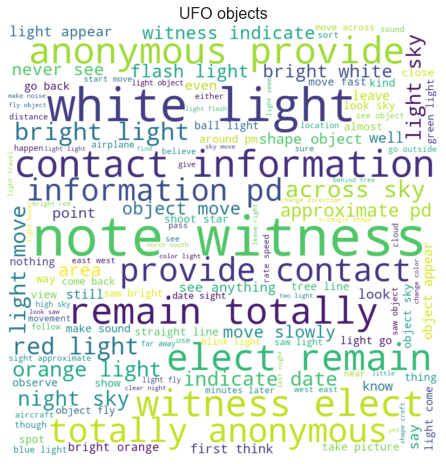

In [339]:
text= ' '.join(df_full['text_clean'])

#Checking most popular words in text feature

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                       
_=plt.figure(figsize = (6, 6), facecolor = None)
_=plt.imshow(wordcloud,interpolation='bilinear')
_=plt.axis("off")
_=plt.tight_layout(pad = 0)
_=plt.title('UFO objects',size=16)

plt.show()

In [119]:
from collections import Counter
cnt = Counter()
for text in df_full["text_clean"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('light', 179740),
 ('object', 96922),
 ('sky', 85762),
 ('move', 75912),
 ('look', 72373),
 ('saw', 61816),
 ('like', 58387),
 ('go', 56224),
 ('one', 48528),
 ('bright', 46829)]

In [120]:
# Removing the frequent words
freq = set([w for (w, wc) in cnt.most_common(10)])

# function to remove the frequent words
def freqwords(text):
    return " ".join([word for word in str(text).split() if word not in freq])

# Passing the function freqwords
df_full["text_common"] = df_full["text_clean"].apply(freqwords)
df_full["text_common"].head()

0    wife drive southeast fairly populate main side...
1    think may catch nbc nightly news air march st ...
2    drive towards intersection fallowfield eagleso...
3    peoria arizona cigar shape craft float neighbo...
4    flash green blue red white revolve around hove...
Name: text_common, dtype: object

### Topic modelling

In [486]:
doc_clean=[clean_text(doc).split() for doc in df_full['text_common']]

In [487]:
dictionary=corpora.Dictionary(doc_clean)
doc_term_matrix=[dictionary.doc2bow(doc) for doc in doc_clean]

In [492]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [493]:
print(lda_model.print_topics(num_topics=6))

[(0, '0.021*"orb" + 0.019*"approximately" + 0.018*"time" + 0.018*"aircraft" + 0.016*"horizon" + 0.015*"north" + 0.015*"would" + 0.012*"area" + 0.012*"witness" + 0.011*"sight"'), (1, '0.023*"fly" + 0.019*"shape" + 0.018*"craft" + 0.015*"west" + 0.012*"sound" + 0.011*"travel" + 0.011*"cloud" + 0.011*"east" + 0.011*"think" + 0.010*"right"'), (2, '0.023*"get" + 0.017*"take" + 0.017*"say" + 0.016*"know" + 0.014*"come" + 0.014*"back" + 0.013*"towards" + 0.013*"could" + 0.013*"time" + 0.012*"house"'), (3, '0.030*"still" + 0.026*"video" + 0.022*"think" + 0.016*"next" + 0.013*"event" + 0.012*"strange" + 0.012*"type" + 0.011*"find" + 0.011*"morning" + 0.010*"talk"'), (4, '0.039*"bright" + 0.026*"red" + 0.024*"white" + 0.023*"disappear" + 0.022*"star" + 0.021*"orange" + 0.016*"flash" + 0.016*"appear" + 0.015*"second" + 0.015*"minutes"'), (5, '0.136*"note" + 0.126*"pd" + 0.094*"witness" + 0.082*"remain" + 0.078*"contact" + 0.075*"information" + 0.074*"provide" + 0.070*"totally" + 0.069*"anonymous"

In [494]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix)) 


Perplexity:  -7.674445997602235


<AxesSubplot:>

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 4')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 5')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

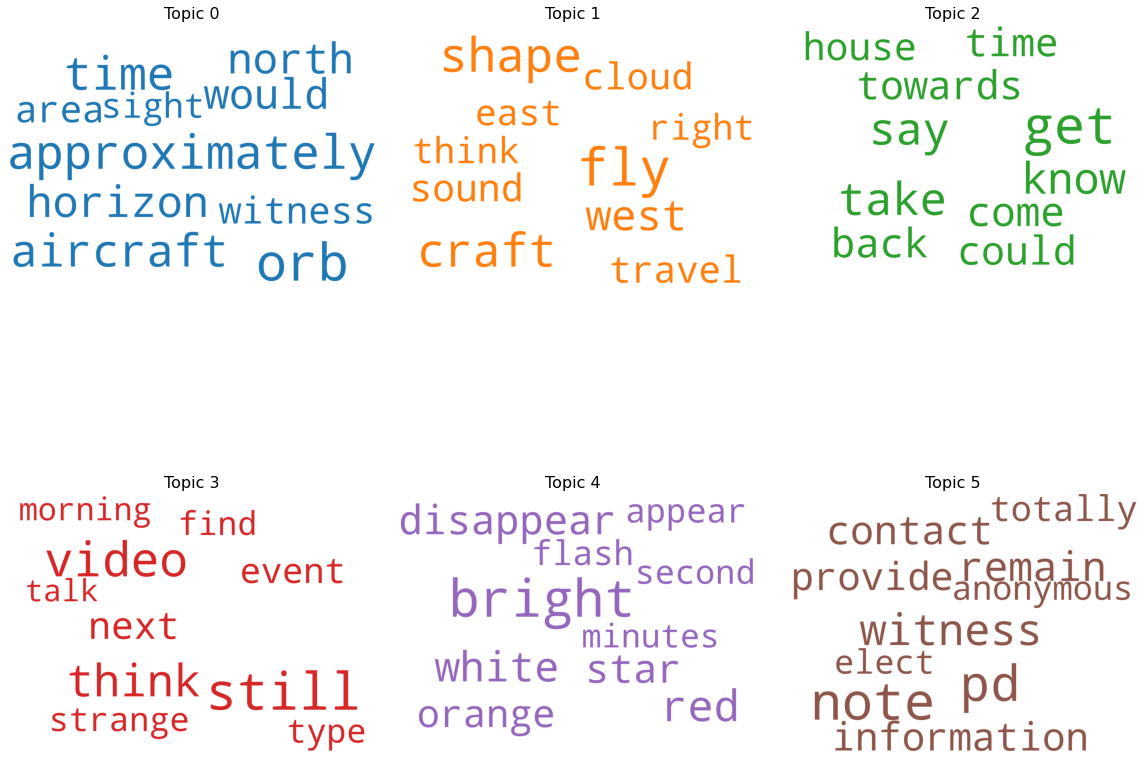

In [495]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10, #top 10 words
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'orb'),
 Text(1, 0, 'approximately'),
 Text(2, 0, 'time'),
 Text(3, 0, 'aircraft'),
 Text(4, 0, 'horizon'),
 Text(5, 0, 'north'),
 Text(6, 0, 'would'),
 Text(7, 0, 'area'),
 Text(8, 0, 'witness'),
 Text(9, 0, 'sight')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'fly'),
 Text(1, 0, 'shape'),
 Text(2, 0, 'craft'),
 Text(3, 0, 'west'),
 Text(4, 0, 'sound'),
 Text(5, 0, 'travel'),
 Text(6, 0, 'cloud'),
 Text(7, 0, 'east'),
 Text(8, 0, 'think'),
 Text(9, 0, 'right')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'get'),
 Text(1, 0, 'take'),
 Text(2, 0, 'say'),
 Text(3, 0, 'know'),
 Text(4, 0, 'come'),
 Text(5, 0, 'back'),
 Text(6, 0, 'towards'),
 Text(7, 0, 'could'),
 Text(8, 0, 'time'),
 Text(9, 0, 'house')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'still'),
 Text(1, 0, 'video'),
 Text(2, 0, 'think'),
 Text(3, 0, 'next'),
 Text(4, 0, 'event'),
 Text(5, 0, 'strange'),
 Text(6, 0, 'type'),
 Text(7, 0, 'find'),
 Text(8, 0, 'morning'),
 Text(9, 0, 'talk')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, 'bright'),
 Text(1, 0, 'red'),
 Text(2, 0, 'white'),
 Text(3, 0, 'disappear'),
 Text(4, 0, 'star'),
 Text(5, 0, 'orange'),
 Text(6, 0, 'flash'),
 Text(7, 0, 'appear'),
 Text(8, 0, 'second'),
 Text(9, 0, 'minutes')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, 'note'),
 Text(1, 0, 'pd'),
 Text(2, 0, 'witness'),
 Text(3, 0, 'remain'),
 Text(4, 0, 'contact'),
 Text(5, 0, 'information'),
 Text(6, 0, 'provide'),
 Text(7, 0, 'totally'),
 Text(8, 0, 'anonymous'),
 Text(9, 0, 'elect')]

No handles with labels found to put in legend.


Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

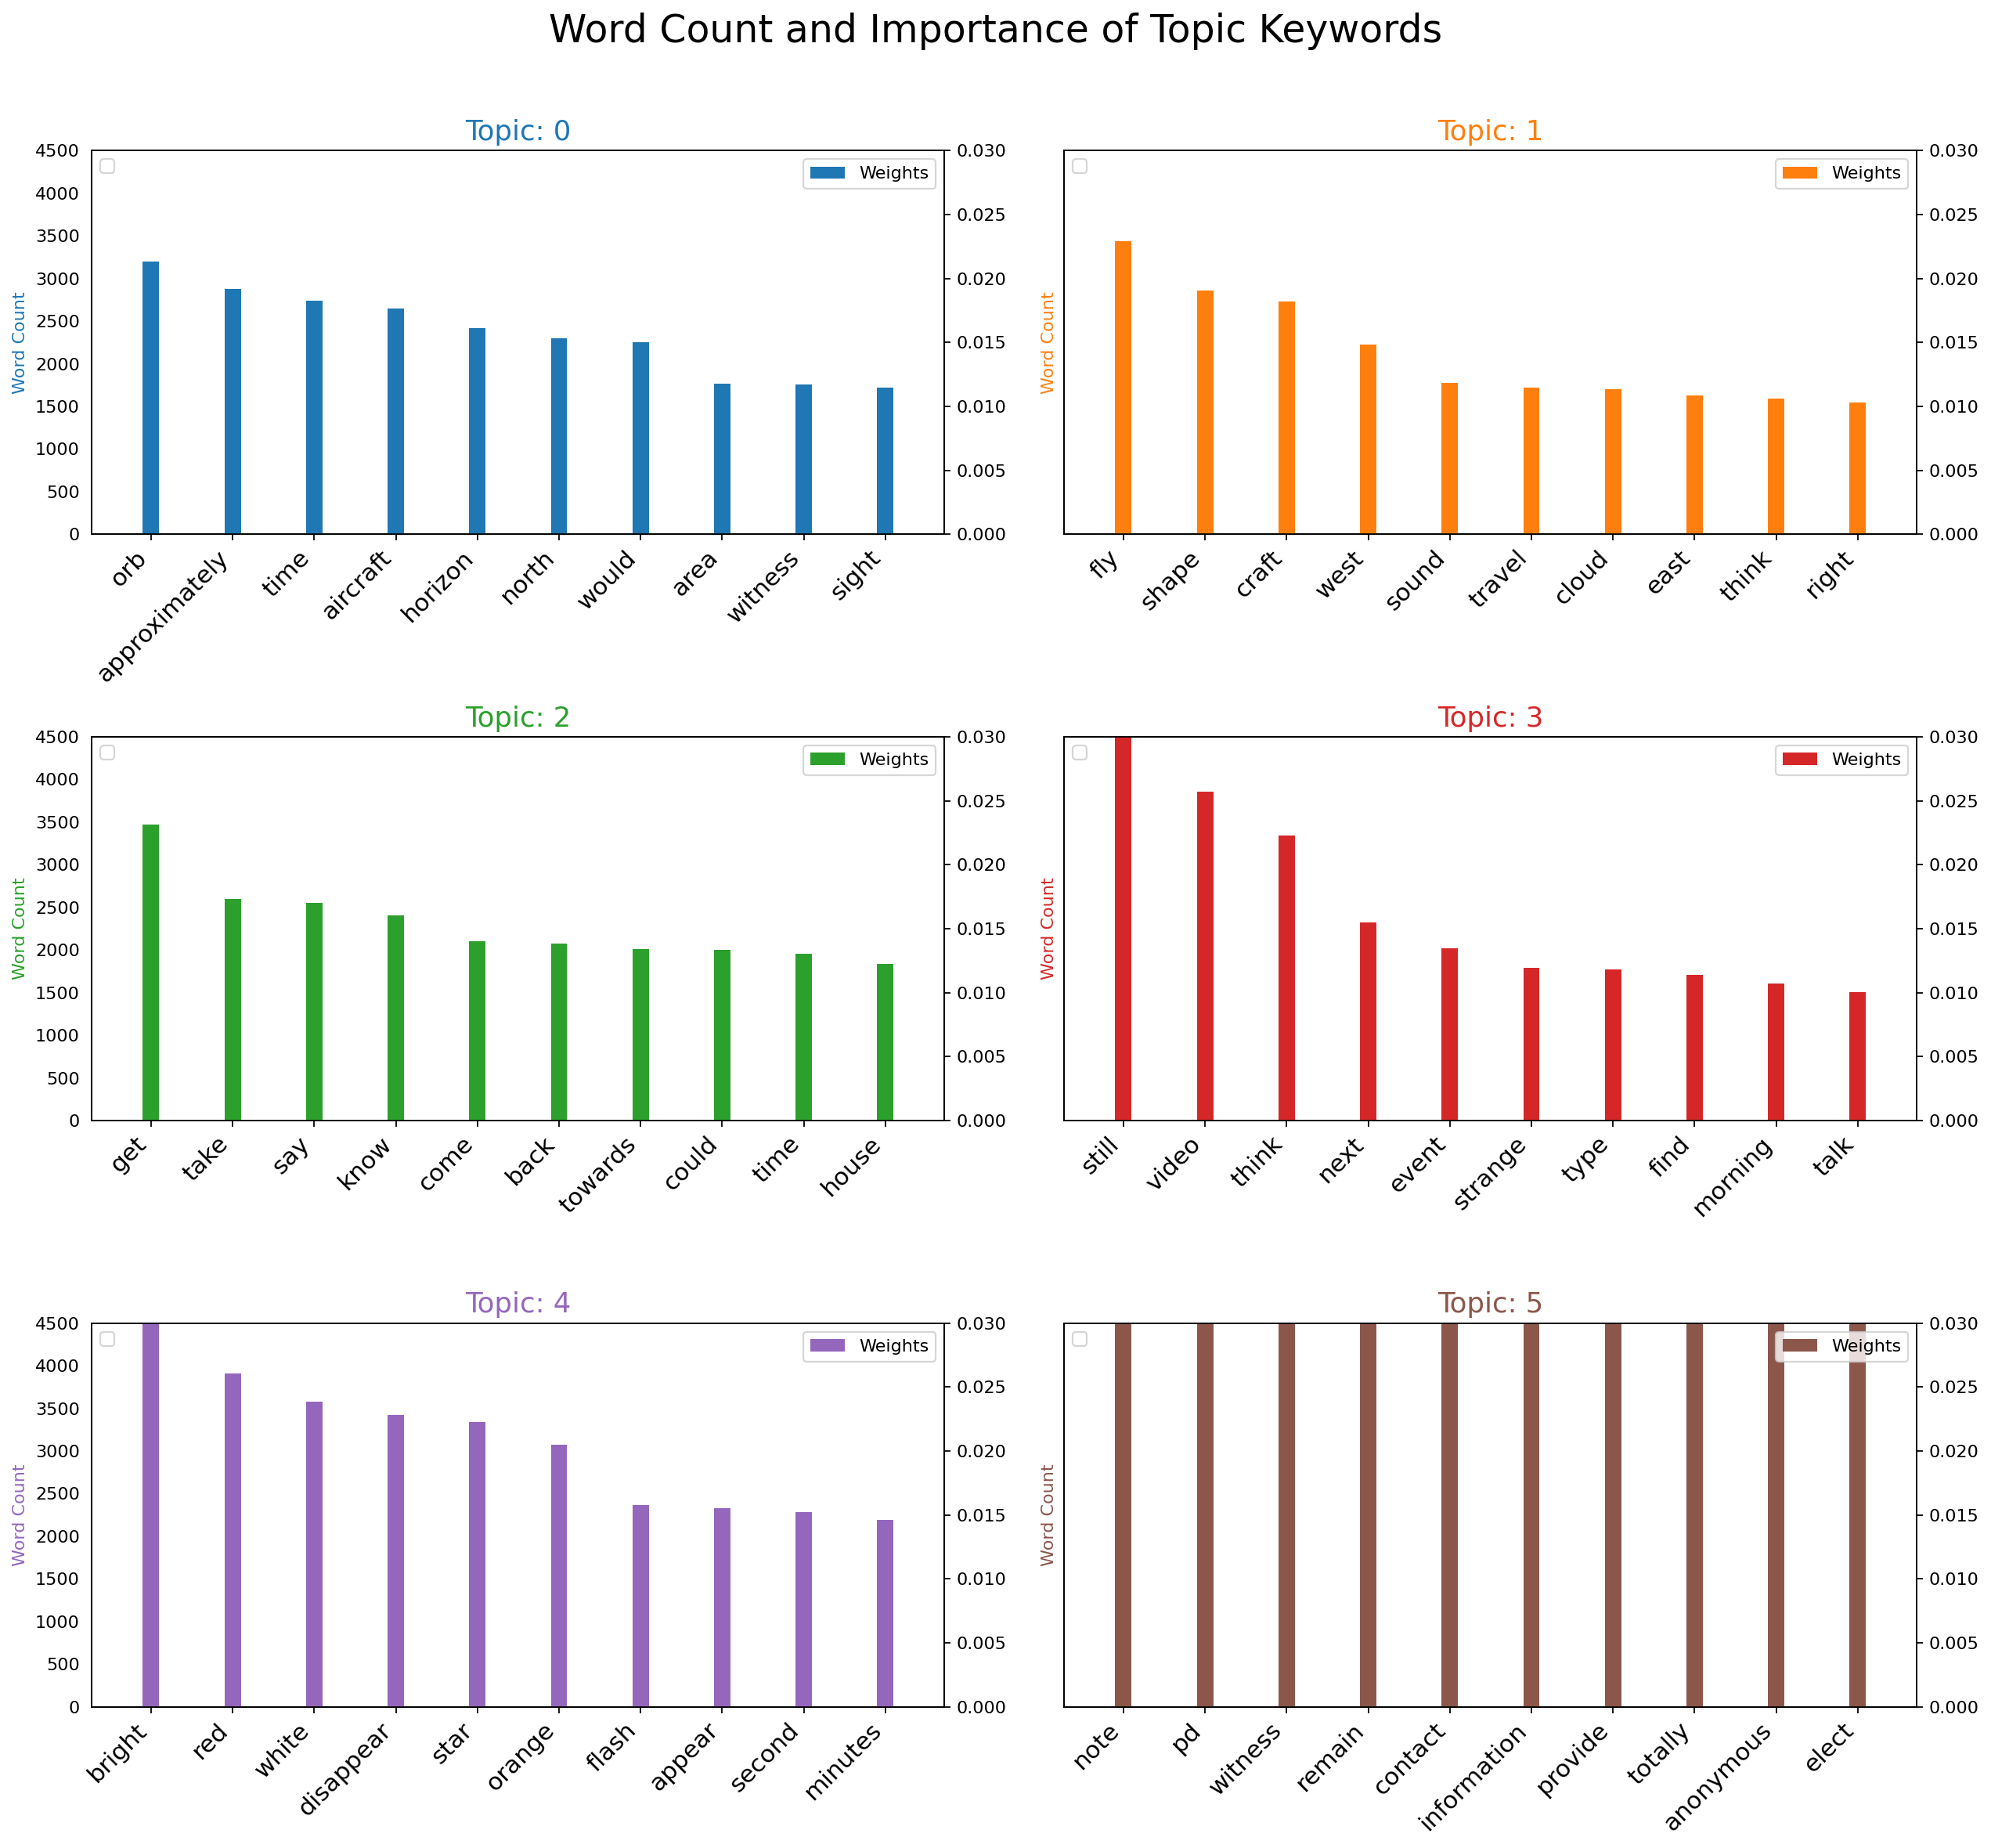

In [496]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df_full['text_common'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_ = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,14), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_.loc[df_.topic_id==i, :], color=cols[i], width=0.5, alpha=0)
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_.loc[df_.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 4500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_.loc[df_.topic_id==i, 'word'], rotation=45, horizontalalignment= 'right',size=14)
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Features from Text

In [121]:
import textstat

df_full["text_len"]=df_full["text"].apply(lambda x:len(x)-x.count(" "))
#readability scores
df_full['flesch_reading_ease']=df_full['text'].apply(textstat.flesch_reading_ease)
df_full['automated_readability']=df_full['text'].apply(textstat.automated_readability_index)
#counts the number of words present in the text
df_full['lexicon_count']=df_full['text'].apply(textstat.lexicon_count,removepunct=True)
df_full['speed_fast']=[word.count('fast') for word in df_full['text']]
df_full['speed_slow']=[word.count('slow') for word in df_full['text']]
df_full['speed_high']=[word.count('high speed') for word in df_full['text']]
df_full['text_exclamation']=[word.count('!') for word in df_full['text']]

In [122]:
def count_capitalized(text):
    count=sum([1 for char in text if char.isupper()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df_full["text_capitalized"]=df_full["text"].apply(lambda x:count_capitalized(x))

In [123]:
def count_punctuation(text):
    count=sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100 

df_full["text_punctuation"]=df_full["text"].apply(lambda x:count_punctuation(x)) 

In [124]:
def count_digit(text):
    count=sum([1 for char in text if char.isdigit()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df_full["text_digit"]=df_full["text"].apply(lambda x:count_digit(x))  

In [126]:
df_full.columns

Index(['posted', 'delta_posted_event_winsorized', 'WATER_BODY_AZIMUTH',
       'fTemp_winsorized', 'season', 'WATER_BODY_NAME_surrogate', 'date_time',
       'ufo_minute_sin', 'city_clean', 'bIsNearWater', 'sConditions_surrogate',
       'ufo_hour_sin', 'AIRPORT_AZIMUTH', 'AIRPORT_DISTANCE', 'ufo_minute',
       'ufo_day_cos', 'ufo_month_cos', 'ufo_weekday_cos', 'country_python',
       'ufo_day_sin', 'precip_winsorized', 'ufo_month_sin', 'ufo_hour_cos',
       'ufo_weekday_number', 'ufo_month', 'Text_ID', 'ufo_hour', 'ufo_year',
       'ufo_day', 'shape_surrogate', 'fTemp_surrogate', 'time_of_day',
       'sentiment', 'WATER_BODY_DISTANCE', 'ufo_minute_cos', 'text',
       'ufo_weekday_sin', 'visibility_surrogate', 'precip_surrogate',
       'visibility_winsorized', 'ufo_weekday_name', 'Duration Category',
       'state_CA', 'state_FL', 'state_Other_state', 'state_Outside US/Canada',
       'state_TX', 'state_WA', 'shape_Other_shape', 'shape_ball',
       'shape_changing', 'shape_cyli

In [127]:
df_full.drop(['country_python','text','ufo_weekday_number','ufo_weekday_name','ufo_month','ufo_minute', 'ufo_hour',
              'date_time', 'ufo_day','ufo_year','city_clean','posted','text_clean'],axis=1,inplace=True) 

In [128]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_full[0:3]

,delta_posted_event_winsorized,WATER_BODY_AZIMUTH,fTemp_winsorized,season,WATER_BODY_NAME_surrogate,ufo_minute_sin,bIsNearWater,sConditions_surrogate,ufo_hour_sin,AIRPORT_AZIMUTH,AIRPORT_DISTANCE,ufo_day_cos,ufo_month_cos,ufo_weekday_cos,ufo_day_sin,precip_winsorized,ufo_month_sin,ufo_hour_cos,Text_ID,shape_surrogate,fTemp_surrogate,time_of_day,sentiment,WATER_BODY_DISTANCE,ufo_minute_cos,ufo_weekday_sin,visibility_surrogate,precip_surrogate,visibility_winsorized,Duration Category,state_CA,state_FL,state_Other_state,state_Outside US/Canada,state_TX,state_WA,shape_Other_shape,shape_ball,shape_changing,shape_cylinder,shape_disk,shape_geometric,shape_light,shape_other,WATER_BODY_NAME_Atlantic Ocean,WATER_BODY_NAME_Chesapeake Bay,WATER_BODY_NAME_Gulf of Mexico,WATER_BODY_NAME_Lake Erie,WATER_BODY_NAME_Lake Michigan,WATER_BODY_NAME_Other_WATER_BODY_NAME,WATER_BODY_NAME_Pacific Ocean,WATER_BODY_NAME_Unknown,bIsRuralArea_Unknown,bIsRuralArea_rural,bIsRuralArea_urban,sConditions_Clear,sConditions_Drizzle,sConditions_Fog,sConditions_Haze,sConditions_Mist,sConditions_Other_sConditions,sConditions_Rain,text_common,text_len,flesch_reading_ease,automated_readability,lexicon_count,speed_fast,speed_slow,speed_high,text_exclamation,text_capitalized,text_punctuation,text_digit
0,10,109.4,-0.3,Winter,0,-1.0,1,0,-1.0,23.6,19630.4,-0.8,1.0,-0.2,0.6,0.0,-0.0,-0.3,1,0,0,Evening,-1,10600.2,-0.3,1.0,0,0,16.0,seconds,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,wife drive southeast fairly populate main side...,773,59.5,16.8,184,0,1,0,1,1.6,2.6,0.5
1,7,177.9,5.1,Spring,0,0.1,1,0,-1.0,-6.8,30661.9,-0.1,0.0,-0.9,-1.0,3.5,1.0,-0.3,2,0,0,Evening,0,37413.9,-1.0,0.4,0,0,12.7,seconds,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,think may catch nbc nightly news air march st ...,292,80.7,9.6,73,0,1,0,0,5.5,3.8,3.8
2,2,-177.6,6.9,Spring,0,-0.1,1,0,0.3,154.8,7232.8,-0.9,-0.5,0.6,-0.4,0.0,0.9,1.0,4,0,0,Night,-1,102885.7,1.0,0.8,0,0,24.0,seconds,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,drive towards intersection fallowfield eagleso...,216,38.7,23.8,49,1,0,0,0,2.8,1.9,0.0


FeatureCorrelation(ax=<AxesSubplot:>, method='mutual_info-classification',
                   sort=True)

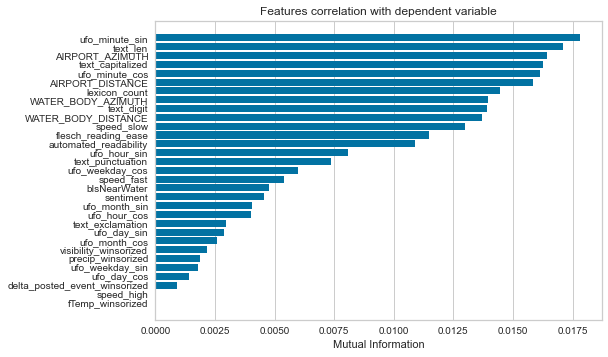

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [129]:
#looking at feature correlation with target feature
from yellowbrick.target import FeatureCorrelation

df_corr=df_full.copy()
df_corr.drop(['Text_ID'],axis=1,inplace=True)
df_vis=df_corr.select_dtypes(include = ['float64', 'int64'])
df_vis=df_vis.dropna(axis=0)

visualizer = FeatureCorrelation(method='mutual_info-classification', sort=True)
visualizer.fit(df_vis.loc[:], df_corr["Duration Category"], random_state=0)
visualizer.poof()

In [134]:
df_full = df_full.drop(df_full[df_full['text_common']==''].index)

In [234]:
df_full_copy=df_full.copy()

In [235]:
df_full_copy.drop('Text_ID',axis=1,inplace=True)

In [236]:
dictionary={'minutes':0,'seconds':1,'Unknown':2,'hours':3,'nights':4}

df_full_copy['Duration Category']=df_full_copy['Duration Category'].map(dictionary)

In [237]:
X = df_full_copy.drop("Duration Category",axis=1)
y = df_full_copy[['Duration Category']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

In [238]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

In [196]:
numerical_features

Index(['delta_posted_event_winsorized', 'WATER_BODY_AZIMUTH',
       'fTemp_winsorized', 'ufo_minute_sin', 'bIsNearWater', 'ufo_hour_sin',
       'AIRPORT_AZIMUTH', 'AIRPORT_DISTANCE', 'ufo_day_cos', 'ufo_month_cos',
       'ufo_weekday_cos', 'ufo_day_sin', 'precip_winsorized', 'ufo_month_sin',
       'ufo_hour_cos', 'sentiment', 'WATER_BODY_DISTANCE', 'ufo_minute_cos',
       'ufo_weekday_sin', 'visibility_winsorized', 'text_len',
       'flesch_reading_ease', 'automated_readability', 'lexicon_count',
       'speed_fast', 'speed_slow', 'speed_high', 'text_exclamation',
       'text_capitalized', 'text_punctuation', 'text_digit'],
      dtype='object')

In [239]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for v in numerical_features:
    scale=scaler.fit(X_train[[v]])
    X_train[v]=scale.transform(X_train[[v]])
    X_test[v]=scale.transform(X_test[[v]])   

In [240]:
#Ordinal encoding season
oe=OrdinalEncoder()
oe.fit(X_train[['season']])
X_train['season']=oe.transform(X_train[['season']])
X_test['season']=oe.transform(X_test[['season']])

OrdinalEncoder()

In [241]:
#Ordinal encoding time of day
oe = OrdinalEncoder()
oe.fit(X_train[['time_of_day']])
X_train['time_of_day']=oe.transform(X_train[['time_of_day']])
X_test['time_of_day']=oe.transform(X_test[['time_of_day']])

OrdinalEncoder()

In [242]:
print(X_train.shape)
print(y_train.shape)

(55411, 72)
(55411, 1)


### Clustering

In [243]:
#selecting highly correlated features with response variable to perform clustering on
numerical_features_cluster=X_train[['AIRPORT_DISTANCE','AIRPORT_AZIMUTH','WATER_BODY_AZIMUTH','WATER_BODY_DISTANCE']].columns

KMeans(n_clusters=2, random_state=42)

KMeans(n_clusters=3, random_state=42)

KMeans(n_clusters=4, random_state=42)

KMeans(n_clusters=5, random_state=42)

KMeans(n_clusters=6, random_state=42)

KMeans(n_clusters=7, random_state=42)

KMeans(random_state=42)

KMeans(n_clusters=9, random_state=42)

Text(0.5, 0, 'k')

Text(0, 0.5, 'WCSS')

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

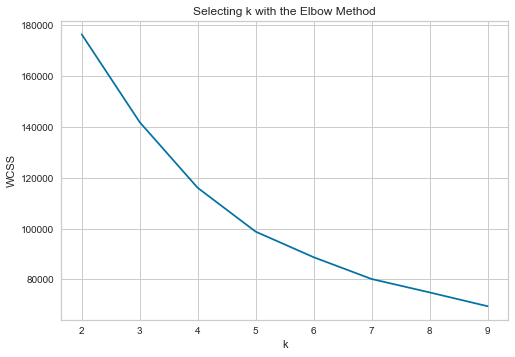

In [157]:
#Finding number of clusters using elbow method

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
clusters=range(2,10)
wcss = []

for k in clusters:
    model=KMeans(n_clusters=k, init="k-means++", random_state = 42) 
    model.fit(X_train[numerical_features_cluster]) 
    prediction=model.predict(X_train[numerical_features_cluster])
    wcss.append(model.inertia_)

plt.plot(clusters, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Selecting k with the Elbow Method')

In [244]:
model=KMeans(n_clusters=4) 
model.fit(X_train[numerical_features_cluster])
prediction_x=model.predict(X_train[numerical_features_cluster])
prediction_x

KMeans(n_clusters=4)

array([1, 1, 0, ..., 0, 1, 0])

In [245]:
prediction_y=model.predict(X_test[numerical_features_cluster])
prediction_y

array([0, 3, 1, ..., 0, 1, 1])

In [160]:
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance, KElbowVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_score(X_train[numerical_features_cluster],model.labels_) 

0.26550210580311995

SilhouetteVisualizer(ax=<AxesSubplot:>, model=None)

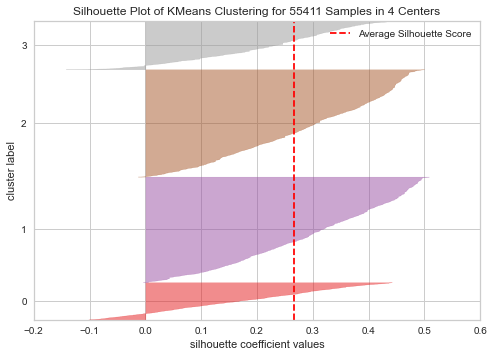

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55411 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [161]:
visualizer = SilhouetteVisualizer(model)
visualizer.fit(X_train[numerical_features_cluster])
visualizer.poof()
fig = visualizer.ax.get_figure()

In [246]:
X_train['cluster'] = prediction_x
X_test['cluster'] = prediction_y

In [247]:
print(X_train.shape)
print(y_train.shape)

(55411, 73)
(55411, 1)


In [165]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     X_train.head()

,delta_posted_event_winsorized,WATER_BODY_AZIMUTH,fTemp_winsorized,season,WATER_BODY_NAME_surrogate,ufo_minute_sin,bIsNearWater,sConditions_surrogate,ufo_hour_sin,AIRPORT_AZIMUTH,AIRPORT_DISTANCE,ufo_day_cos,ufo_month_cos,ufo_weekday_cos,ufo_day_sin,precip_winsorized,ufo_month_sin,ufo_hour_cos,shape_surrogate,fTemp_surrogate,time_of_day,sentiment,WATER_BODY_DISTANCE,ufo_minute_cos,ufo_weekday_sin,visibility_surrogate,precip_surrogate,visibility_winsorized,state_CA,state_FL,state_Other_state,state_Outside US/Canada,state_TX,state_WA,shape_Other_shape,shape_ball,shape_changing,shape_cylinder,shape_disk,shape_geometric,shape_light,shape_other,WATER_BODY_NAME_Atlantic Ocean,WATER_BODY_NAME_Chesapeake Bay,WATER_BODY_NAME_Gulf of Mexico,WATER_BODY_NAME_Lake Erie,WATER_BODY_NAME_Lake Michigan,WATER_BODY_NAME_Other_WATER_BODY_NAME,WATER_BODY_NAME_Pacific Ocean,WATER_BODY_NAME_Unknown,bIsRuralArea_Unknown,bIsRuralArea_rural,bIsRuralArea_urban,sConditions_Clear,sConditions_Drizzle,sConditions_Fog,sConditions_Haze,sConditions_Mist,sConditions_Other_sConditions,sConditions_Rain,text_common,text_len,flesch_reading_ease,automated_readability,lexicon_count,speed_fast,speed_slow,speed_high,text_exclamation,text_capitalized,text_punctuation,text_digit,cluster
65848,-0.4,-0.1,-1.3,0.0,1,-0.2,-1.8,0,-0.9,-0.1,-0.9,-1.4,1.3,-1.1,0.3,-0.5,-0.5,-0.6,0,0,1.0,0.8,-0.7,0.9,-0.6,0,0,0.2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,almost fullmoon appear distance tree full moon...,-0.4,0.2,-0.2,-0.4,-0.4,-0.5,-0.1,-0.2,-0.3,0.7,-0.4,1
62192,-0.4,-1.3,-1.7,3.0,0,-0.2,0.5,0,2.4,0.3,0.5,1.2,1.3,1.0,-0.6,-0.5,0.9,-1.0,0,0,2.0,-1.4,-0.6,0.9,1.2,0,0,0.2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,travel west hwy notice something far enough ha...,-0.7,0.8,-0.8,-0.6,-0.4,-0.5,-0.1,-0.2,-0.2,0.0,-0.2,1
60137,-0.4,1.1,0.7,2.0,0,-0.2,0.5,0,-0.1,0.8,0.9,-0.5,-0.6,-1.1,1.4,-0.5,-1.1,0.9,0,0,1.0,0.8,0.3,0.9,-0.6,0,0,-0.3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,think satellite near big dipperthe get brighte...,-0.8,0.4,-0.4,-0.8,-0.4,-0.5,-0.1,-0.2,-0.3,3.0,-0.6,2
66431,-0.4,-1.6,1.4,0.0,0,-0.2,0.5,0,-0.9,-0.7,-0.8,-1.3,0.1,-0.2,-0.6,-0.5,-1.3,-0.1,0,0,1.0,0.8,2.6,0.9,1.4,0,0,0.7,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,fy beside clear fireballs beside different dir...,-0.7,0.6,-0.7,-0.7,-0.4,-0.5,-0.1,-0.2,-0.3,-1.0,-0.1,3
32175,-0.4,-1.6,0.3,0.0,0,1.9,0.5,0,-0.9,0.6,-0.7,-1.4,1.3,1.0,0.3,-0.5,-0.5,-0.6,0,0,1.0,0.8,0.1,-0.1,-1.1,0,0,-0.3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,darker blue faster jet fighter gainesville fl ...,-0.3,0.2,0.0,-0.2,2.7,-0.5,-0.1,-0.2,0.1,-0.1,-0.0,2


In [248]:
y_train.value_counts()

Duration Category
0                    33360
1                    14472
2                     3711
3                     3264
4                      604
dtype: int64

In [249]:
from imblearn.over_sampling import RandomOverSampler 

# define oversample strategy
oversample = RandomOverSampler()

# fit and apply the transform
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

In [207]:
X_resampled.shape

(166800, 73)

In [250]:
y_resampled.value_counts()

Duration Category
0                    33360
1                    33360
2                    33360
3                    33360
4                    33360
dtype: int64

In [251]:
season_feature=['season']
time_of_day=_feature=['time_of_day']
condition_feature=['sConditions']
text='text_common'

all_num_features= X_resampled.select_dtypes(include=['int64', 'float64']).columns

In [261]:
tfidf_vect = TfidfVectorizer(max_df=0.8,min_df=0.02,ngram_range=[1,2])
df_tfidf = tfidf_vect.fit(X_resampled["text_common"])

X_tfidf_train=df_tfidf.transform(X_resampled["text_common"])
X_tfidf_test=df_tfidf.transform(X_test["text_common"])

In [211]:
list(set(X_train.columns))

['delta_posted_event_winsorized',
 'state_TX',
 'automated_readability',
 'bIsRuralArea_rural',
 'WATER_BODY_AZIMUTH',
 'fTemp_winsorized',
 'WATER_BODY_NAME_Lake Michigan',
 'WATER_BODY_NAME_Pacific Ocean',
 'season',
 'sConditions_Clear',
 'WATER_BODY_NAME_surrogate',
 'sConditions_Drizzle',
 'ufo_minute_sin',
 'sConditions_Haze',
 'text_capitalized',
 'lexicon_count',
 'sConditions_surrogate',
 'bIsNearWater',
 'shape_disk',
 'ufo_hour_sin',
 'AIRPORT_AZIMUTH',
 'AIRPORT_DISTANCE',
 'speed_fast',
 'ufo_day_cos',
 'ufo_month_cos',
 'ufo_weekday_cos',
 'sConditions_Rain',
 'speed_slow',
 'ufo_day_sin',
 'precip_winsorized',
 'ufo_month_sin',
 'sConditions_Other_sConditions',
 'text_len',
 'ufo_hour_cos',
 'state_FL',
 'shape_light',
 'state_WA',
 'WATER_BODY_NAME_Gulf of Mexico',
 'bIsRuralArea_Unknown',
 'text_exclamation',
 'flesch_reading_ease',
 'shape_surrogate',
 'state_CA',
 'shape_cylinder',
 'WATER_BODY_NAME_Lake Erie',
 'speed_high',
 'text_common',
 'text_punctuation',
 'st

In [262]:
tfidf_features_train=pd.DataFrame(X_tfidf_train.toarray(),columns=tfidf_vect.get_feature_names())
tfidf_features_test=pd.DataFrame(X_tfidf_test.toarray(),columns=tfidf_vect.get_feature_names())

In [ ]:
list(set(X_train.columns))

In [222]:
tfidf_features_train.columns

Index(['able', 'absolutely', 'across', 'actually', 'ago', 'air', 'aircraft',
       'airplane', 'airplanes', 'airport',
       ...
       'wonder', 'work', 'would', 'write', 'yard', 'year', 'years', 'yellow',
       'yet', 'zoom'],
      dtype='object', length=621)

In [263]:
#Combining all together before proceeding with classification
X_count_features_train=pd.concat([X_resampled.reset_index(drop=True),
                            tfidf_features_train], axis=1)

X_count_features_test=pd.concat([X_test.reset_index(drop=True),
                            tfidf_features_test], axis=1)

In [264]:
#removing already vectorized text feature
X_count_features_train.drop('text_common',axis=1,inplace=True)
X_count_features_test.drop('text_common',axis=1,inplace=True)

In [252]:
X_count_features_train.head()

,delta_posted_event_winsorized,WATER_BODY_AZIMUTH,fTemp_winsorized,season,WATER_BODY_NAME_surrogate,ufo_minute_sin,bIsNearWater,sConditions_surrogate,ufo_hour_sin,AIRPORT_AZIMUTH,...,wonder,work,would,write,yard,year,years,yellow,yet,zoom
0,-0.436749,-0.054676,-1.293834,0.0,1,-0.151876,-1.846414,0,-0.917093,-0.104999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.447949,-1.293652,-1.733244,3.0,0,-0.151876,0.541590,0,2.380175,0.320336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.433015,1.110657,0.706639,2.0,0,-0.151876,0.541590,0,-0.078488,0.799038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.425549,-1.575122,1.446698,0.0,0,-0.151876,0.541590,0,-0.859943,-0.698419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.350880,-1.576678,0.313482,0.0,0,1.917418,0.541590,0,-0.917093,0.594472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [273]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=X_count_features_train.shape[1]-1)
svd.fit(X_count_features_train)

TruncatedSVD(n_components=697)

In [276]:
svd_var_ratios = svd.explained_variance_ratio_ 
svd_var_ratios

array([2.44947936e-02, 8.55372717e-02, 5.73276758e-02, 5.05113361e-02,
       4.67103602e-02, 4.56515323e-02, 4.00583993e-02, 3.51186401e-02,
       3.41721814e-02, 3.16274212e-02, 2.92744274e-02, 2.70876706e-02,
       2.64305115e-02, 2.61267648e-02, 2.54995427e-02, 2.50345170e-02,
       2.46636033e-02, 2.39087011e-02, 2.34002964e-02, 2.32840076e-02,
       2.24791509e-02, 2.21787353e-02, 2.20285830e-02, 2.09491386e-02,
       1.94671856e-02, 1.91846585e-02, 1.79710167e-02, 1.74792508e-02,
       1.69591446e-02, 1.10594012e-02, 9.54439430e-03, 7.49479063e-03,
       5.57877333e-03, 5.30857856e-03, 5.16203201e-03, 5.01339603e-03,
       4.54485889e-03, 4.11980358e-03, 3.84841674e-03, 3.53203467e-03,
       3.00771129e-03, 2.92706364e-03, 2.61808789e-03, 2.51304655e-03,
       1.92324564e-03, 1.82608200e-03, 1.55119384e-03, 1.51101411e-03,
       1.40276734e-03, 1.35961297e-03, 1.22100249e-03, 1.10562497e-03,
       1.08811115e-03, 1.01353383e-03, 9.74114297e-04, 9.21923470e-04,
      

In [277]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [278]:
select_n_components(svd_var_ratios, 0.95)

41

In [284]:
svd = TruncatedSVD(n_components=41)
svd.fit(X_count_features_train)
x_train1=svd.transform(X_count_features_train)
x_test1=svd.transform(X_count_features_test)

TruncatedSVD(n_components=41)